## 0. Импорт библиотек

In [1]:
#Классика жизни
import numpy as np
import pandas as pd
import copy

#Художества
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

#Гипотезы и отклонения
from scipy import stats
from scipy.stats import norm, skew, probplot

#Выбросы
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator

# МГК
from sklearn.decomposition import PCA

# Кластеризация
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from scipy.stats import mode

# t-SNE и UMAP
from sklearn.manifold import TSNE
from umap import UMAP

#Пропуски
from sklearn.impute import SimpleImputer

# Кодирование
from category_encoders import TargetEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler

# Трансформация
from sklearn.preprocessing import FunctionTransformer

# Чтобы сделать все красиво
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Игнорируем всё
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## 1. Обзор данных

In [2]:
df = pd.read_csv('data.csv', sep=',')
df.head()

,SalePrice,MSZoning,LotArea,Utilities,Condition1,Condition2,OverallQual,OverallCond,YearBuilt,YearRemodAdd,...,Fireplaces,FireplaceQu,GarageArea,GarageQual,GarageCond,PoolArea,PoolQC,Fence,MiscFeature,MiscVal
0,208500,RL,8450,AllPub,Norm,Norm,7,5,2003,2003,...,0,NaN,548,TA,TA,0,NaN,NaN,NaN,0
1,181500,RL,9600,AllPub,Feedr,Norm,6,8,1976,1976,...,1,TA,460,TA,TA,0,NaN,NaN,NaN,0
2,223500,RL,11250,AllPub,Norm,Norm,7,5,2001,2002,...,1,TA,608,TA,TA,0,NaN,NaN,NaN,0
3,140000,RL,9550,AllPub,Norm,Norm,7,5,1915,1970,...,1,Gd,642,TA,TA,0,NaN,NaN,NaN,0
4,250000,RL,14260,AllPub,Norm,Norm,8,5,2000,2000,...,1,TA,836,TA,TA,0,NaN,NaN,NaN,0


In [3]:
print(f'Размерность данных: {df.shape}')

Размерность данных: (1460, 37)


Таким образом мы имеем 1460 наблюдений, 36 объясняющих признаков и один результирующий (SalePrice). Теперь рассмотрим типы данных:

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 37 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   SalePrice     1460 non-null   int64 
 1   MSZoning      1460 non-null   object
 2   LotArea       1460 non-null   int64 
 3   Utilities     1460 non-null   object
 4   Condition1    1460 non-null   object
 5   Condition2    1460 non-null   object
 6   OverallQual   1460 non-null   int64 
 7   OverallCond   1460 non-null   int64 
 8   YearBuilt     1460 non-null   int64 
 9   YearRemodAdd  1460 non-null   int64 
 10  RoofStyle     1460 non-null   object
 11  RoofMatl      1460 non-null   object
 12  Exterior1st   1460 non-null   object
 13  Exterior2nd   1460 non-null   object
 14  ExterQual     1460 non-null   object
 15  ExterCond     1460 non-null   object
 16  Foundation    1460 non-null   object
 17  BsmtQual      1423 non-null   object
 18  BsmtCond      1423 non-null   object
 19  TotalB

`Числовые дискретные данные (15):`
* SalePrice (цена продажи жилья в долларах)(результирующий),
* LotArea (общая площадь),
* OverallQual (общая оценка дома),
* OverallCond (общая оценка состояния дома),
* YearBuilt (год постройки дома),
* YearRemodAdd (год капитального ремонта),
* TotalBsmtSF (общая площадь подвала),
* GrLivArea (жилая площадь),
* BedroomAbvGr (спальни выше подвала),
* KitchenAbvGr (кухни выше подвала),
* TotRmsAbvGrd (общее количество комнат выше подвала),
* Fireplaces (количество каминов),
* GarageArea (площадь гаража),
* PoolArea (площадь бассейна),
* MiscVal (значения дополнительных характеристик).

In [5]:
df.describe(include='number')

,SalePrice,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,TotalBsmtSF,GrLivArea,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageArea,PoolArea,MiscVal
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,180921.195890,10516.828082,6.099315,5.575342,1971.267808,1984.865753,1057.429452,1515.463699,2.866438,1.046575,6.517808,0.613014,472.980137,2.758904,43.489041
std,79442.502883,9981.264932,1.382997,1.112799,30.202904,20.645407,438.705324,525.480383,0.815778,0.220338,1.625393,0.644666,213.804841,40.177307,496.123024
min,34900.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,334.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000
25%,129975.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,795.750000,1129.500000,2.000000,1.000000,5.000000,0.000000,334.500000,0.000000,0.000000
50%,163000.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,991.500000,1464.000000,3.000000,1.000000,6.000000,1.000000,480.000000,0.000000,0.000000
75%,214000.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,1298.250000,1776.750000,3.000000,1.000000,7.000000,1.000000,576.000000,0.000000,0.000000
max,755000.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,6110.000000,5642.000000,8.000000,3.000000,14.000000,3.000000,1418.000000,738.000000,15500.000000


`Категориальные данные (22): `
* MSZoning (тип локации, где находится дом), 
* Utilities (коммунальные блага), 
* Condition1 (близость к необходимым объектам), 
* Condition2 (еще один объект, если есть), 
* RoofStyle (RoofStyle), 
* RoofMatl (материал крыши), 
* Exterior1st (материал отделки),
* Exterior2nd (еще один материал отделки),
* ExterQual (качество отделки),
* ExterCond (состояние отделки),
* Foundation (тип фундамента),
* BsmtQual (высота подвала),
* BsmtCond (состояние подвала),
* Heating (тип отопления),
* HeatingQC (качество отопления),
* KitchenQual (качество кухни),
* FireplaceQu (качество каминов),
* GarageQual (качество гаража),
* GarageCond – состояние гаража,
* PoolQC (площадь бассейна),
* Fence (тип забора),
* MiscFeature (дополнительные характеристики).

In [6]:
df.describe(include='object')

,MSZoning,Utilities,Condition1,Condition2,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,ExterQual,ExterCond,...,BsmtCond,Heating,HeatingQC,KitchenQual,FireplaceQu,GarageQual,GarageCond,PoolQC,Fence,MiscFeature
count,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,...,1423,1460,1460,1460,770,1379,1379,7,281,54
unique,5,2,9,8,6,8,15,16,4,5,...,4,6,5,4,5,5,5,3,4,4
top,RL,AllPub,Norm,Norm,Gable,CompShg,VinylSd,VinylSd,TA,TA,...,TA,GasA,Ex,TA,Gd,TA,TA,Gd,MnPrv,Shed
freq,1151,1459,1260,1445,1141,1434,515,504,906,1282,...,1311,1428,741,735,380,1311,1326,3,157,49


Проверка на дубликаты:

In [7]:
df.duplicated().sum()

0

Дубликаты отсутствуют.

Проверка на пропуски:

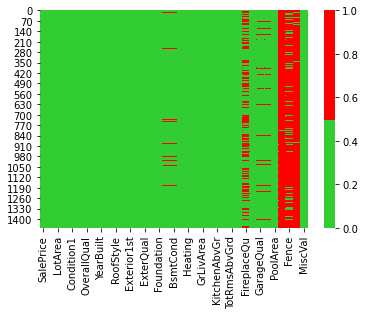

In [8]:
cols = df.columns 
# красный - пропущенные числовые данные, зеленый - не пропущенные
colours = ['limegreen', 'red'] 
sns.heatmap(df[cols].isnull(), cmap=sns.color_palette(colours));

In [9]:
missing = df.isnull().sum()[df.isnull().sum() > 0].sort_values()
missing

BsmtQual         37
BsmtCond         37
GarageQual       81
GarageCond       81
FireplaceQu     690
Fence          1179
MiscFeature    1406
PoolQC         1453
dtype: int64

Как ранее было замечено, наблюдений всего 1460, а в столбцах PoolQC, Fence, MiscFeature пропусков более 1000 штук => есть смысл удалить их совсем, так как они несут в себе мало информации.

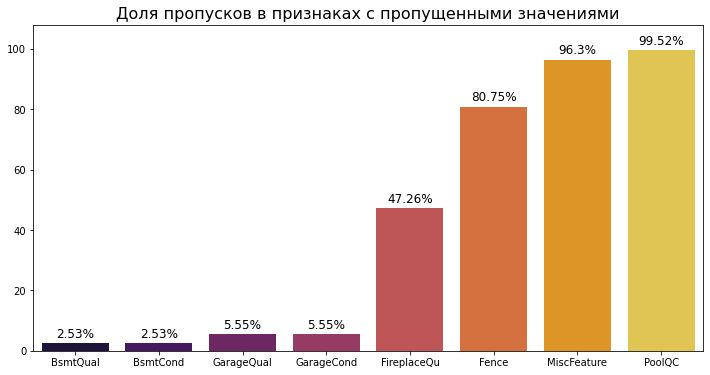

In [10]:
missing_per = (missing/len(df)*100).sort_values()

plt.figure(figsize=(12, 6))
sns.barplot(x=missing_per.index, y=missing_per, palette='inferno')
for i in range(8):
    plt.text(i, missing_per[i] + 2, f'{round(missing_per[i], 2)}%', fontsize=12, ha='center')
plt.ylim([0, 108])
plt.title("Доля пропусков в признаках с пропущенными значениями", fontsize=16);

Разделим признаки на:
* результирующий - цена продажи дома, признак SalePrice;
* числовые (1) - числовые признаки, принимающие не более 22 значений;
* числовые (2) - числовые признаки, принимающие более 22 значений;
* категориальные.

В отдельной переменной объединим числовые признаки.

In [11]:
numerical_discr = [f for f in df.columns if df.dtypes[f] != 'object' and f != 'SalePrice' and df[f].nunique() <= 22]
numerical_cont = [f for f in df.columns if df.dtypes[f] != 'object' and f != 'SalePrice' and df[f].nunique() > 22]
numerical = numerical_cont + numerical_discr
categorial = [f for f in df.columns if df.dtypes[f] == 'object'] 

Посмотрим на корреляцию между признаками.

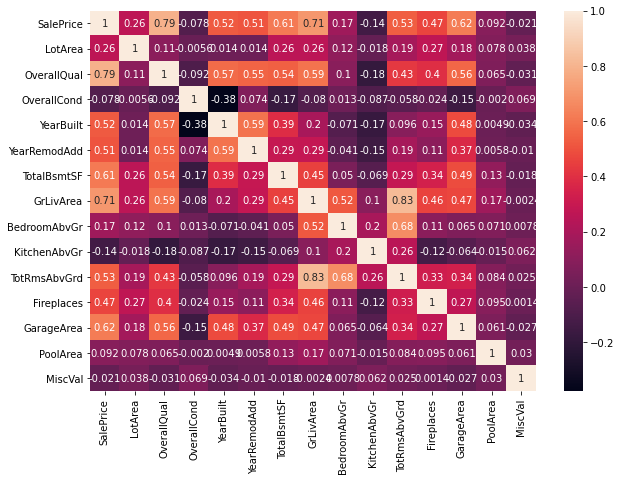

In [12]:
f, ax = plt.subplots(figsize=(10, 7))
highcorr_vars = (abs(df.corr().SalePrice)).index
sns.heatmap(df[highcorr_vars].corr(), annot=True)
plt.show()

Оценим корреляцию числовых признаков с результирующим.

In [13]:
corr = df.corr()[['SalePrice']].sort_values(['SalePrice'], ascending=False)
с1 = corr.style.background_gradient(cmap='RdYlGn')
с1

,SalePrice
SalePrice,1.000000
OverallQual,0.790982
GrLivArea,0.708624
GarageArea,0.623431
TotalBsmtSF,0.613581
TotRmsAbvGrd,0.533723
YearBuilt,0.522897
YearRemodAdd,0.507101
Fireplaces,0.466929
LotArea,0.263843


Выделим признаки с наиболее высокой корреляцией.

In [14]:
corr = corr.abs().sort_values(['SalePrice'], ascending=False)
с1_max = corr[(abs(corr['SalePrice']) > 0.5) & (corr['SalePrice'] != 1)].style.background_gradient(cmap='RdYlGn')
с1_max

,SalePrice
OverallQual,0.790982
GrLivArea,0.708624
GarageArea,0.623431
TotalBsmtSF,0.613581
TotRmsAbvGrd,0.533723
YearBuilt,0.522897
YearRemodAdd,0.507101


Визуализируем признаки.

In [15]:
def cat_plot(feature):
    print(f'Признак {feature} имеет {round(df[feature].isnull().sum()/len(df)*100, 2)}% пропущенных значений')
    f, ax = plt.subplots(1, 2, figsize=(10, 3))
    ax[0].tick_params(axis='x', labelrotation=30)
    ax[1].tick_params(axis='x', labelrotation=30)
    sns.countplot(data=df, x=feature, ax=ax[0]);
    sns.boxplot(data=df, x=feature, y='SalePrice', ax=ax[1])
    plt.show()
    
def num_plot(feature, rotation=90):
    print(f'Признак {feature} имеет {round(df[feature].isnull().sum()/len(df)*100, 2)}% пропущенных значений')
    f, ax = plt.subplots(1, 2, figsize=(10, 3))
    ax[0].tick_params(axis='x', labelrotation=30)
    ax[1].tick_params(axis='x', labelrotation=30)
    sns.scatterplot(data=df, x=feature, y='SalePrice', ax=ax[0]);
    sns.boxplot(data=df, x=feature, ax=ax[1])
    plt.show()

Признак MSZoning имеет 0.0% пропущенных значений


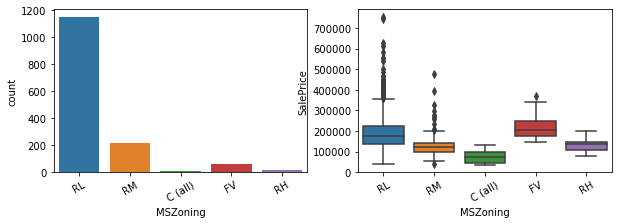

Признак Utilities имеет 0.0% пропущенных значений


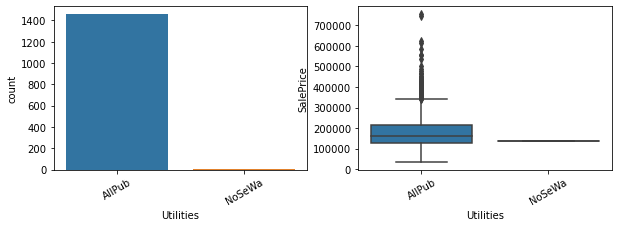

Признак Condition1 имеет 0.0% пропущенных значений


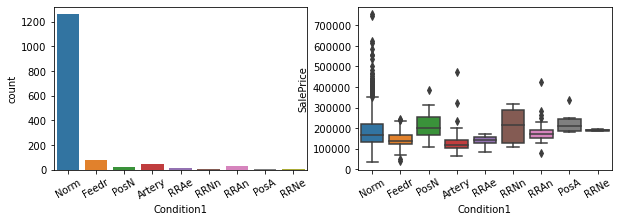

Признак Condition2 имеет 0.0% пропущенных значений


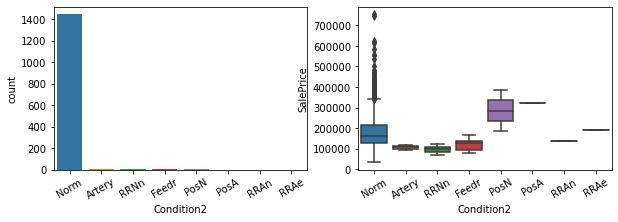

Признак RoofStyle имеет 0.0% пропущенных значений


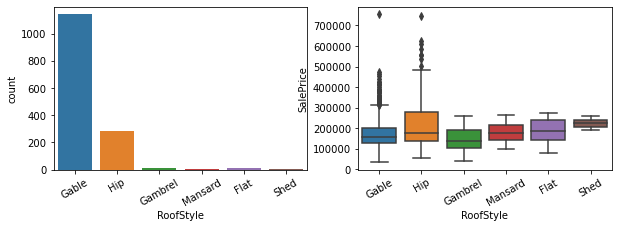

Признак RoofMatl имеет 0.0% пропущенных значений


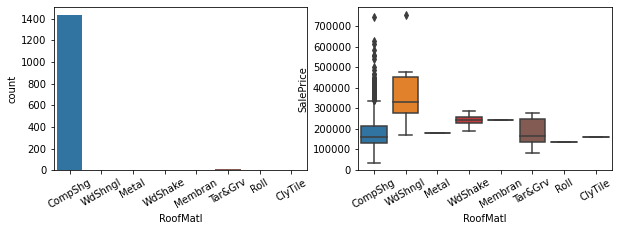

Признак Exterior1st имеет 0.0% пропущенных значений


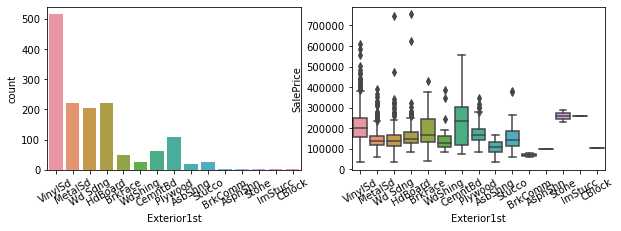

Признак Exterior2nd имеет 0.0% пропущенных значений


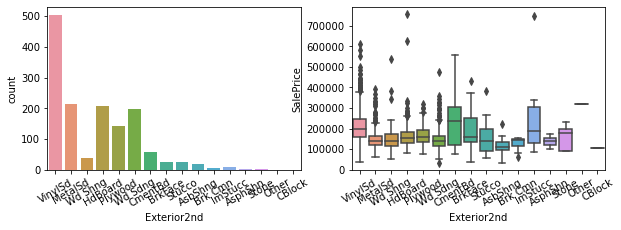

Признак ExterQual имеет 0.0% пропущенных значений


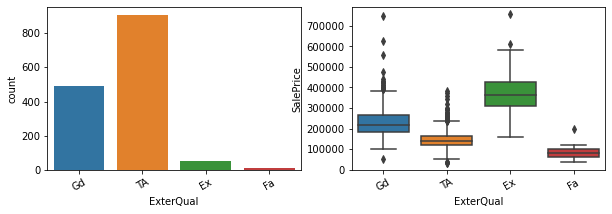

Признак ExterCond имеет 0.0% пропущенных значений


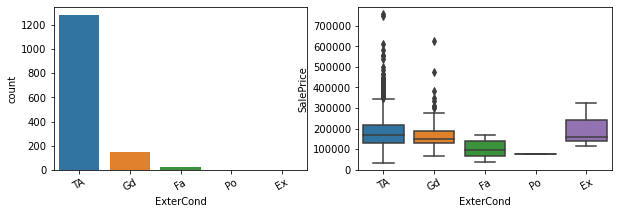

Признак Foundation имеет 0.0% пропущенных значений


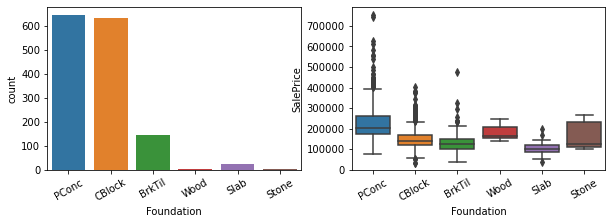

Признак BsmtQual имеет 2.53% пропущенных значений


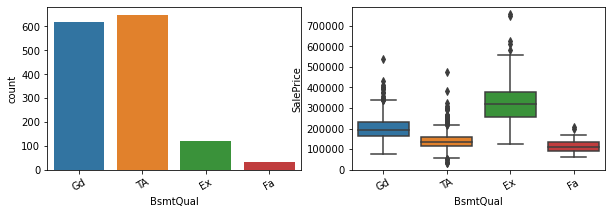

Признак BsmtCond имеет 2.53% пропущенных значений


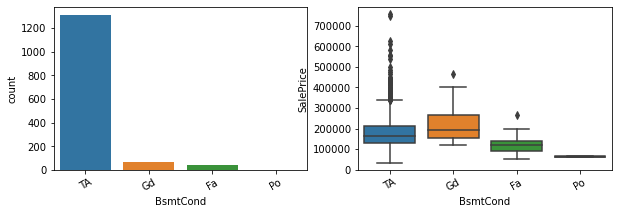

Признак Heating имеет 0.0% пропущенных значений


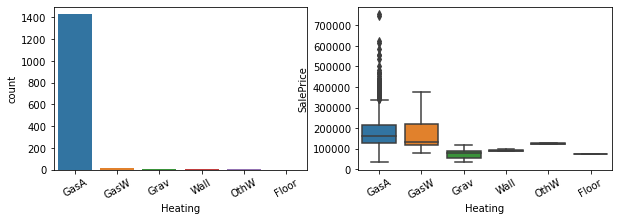

Признак HeatingQC имеет 0.0% пропущенных значений


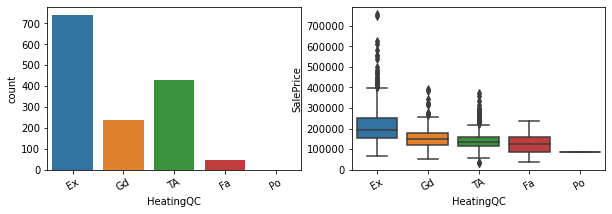

Признак KitchenQual имеет 0.0% пропущенных значений


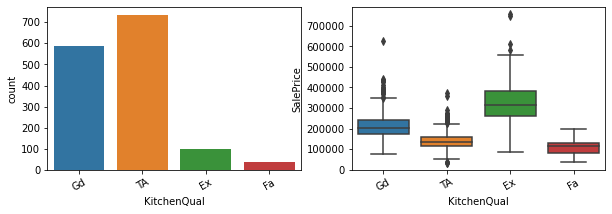

Признак FireplaceQu имеет 47.26% пропущенных значений


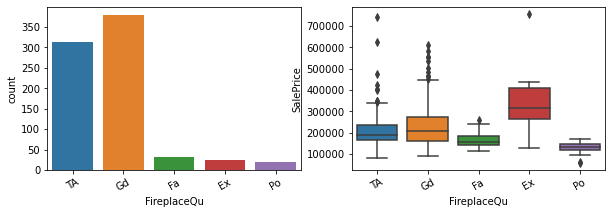

Признак GarageQual имеет 5.55% пропущенных значений


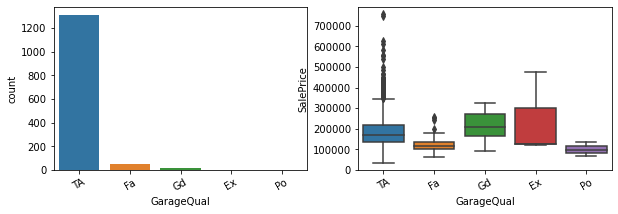

Признак GarageCond имеет 5.55% пропущенных значений


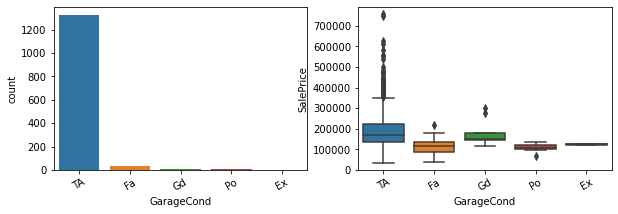

Признак PoolQC имеет 99.52% пропущенных значений


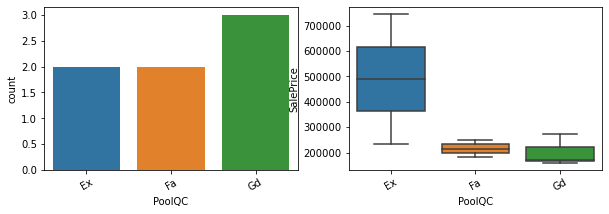

Признак Fence имеет 80.75% пропущенных значений


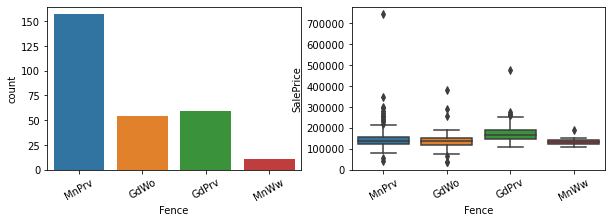

Признак MiscFeature имеет 96.3% пропущенных значений


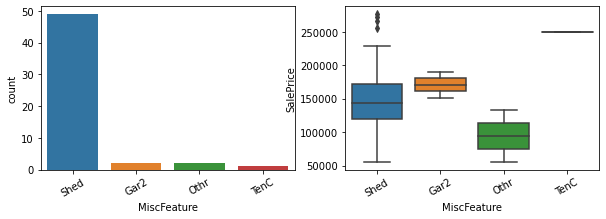

Признак OverallQual имеет 0.0% пропущенных значений


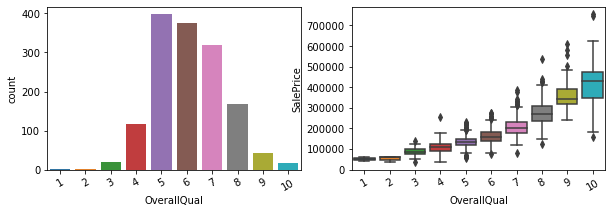

Признак OverallCond имеет 0.0% пропущенных значений


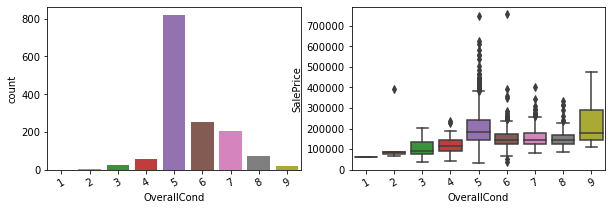

Признак BedroomAbvGr имеет 0.0% пропущенных значений


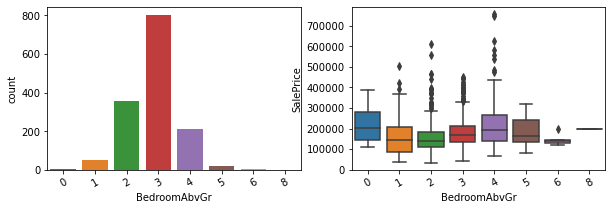

Признак KitchenAbvGr имеет 0.0% пропущенных значений


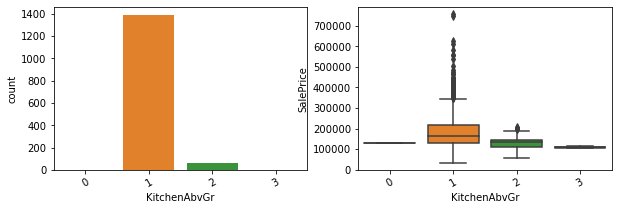

Признак TotRmsAbvGrd имеет 0.0% пропущенных значений


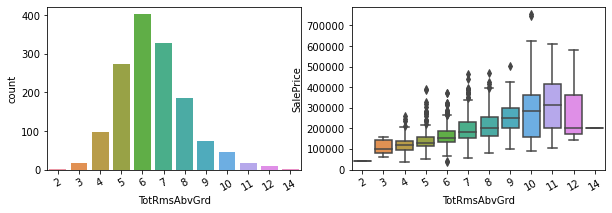

Признак Fireplaces имеет 0.0% пропущенных значений


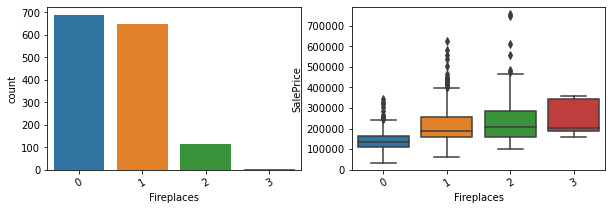

Признак PoolArea имеет 0.0% пропущенных значений


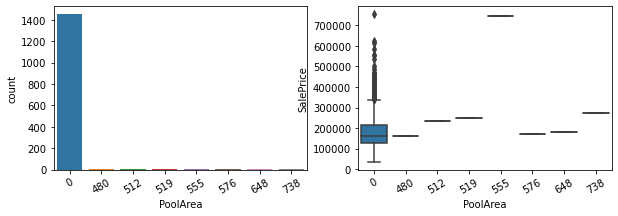

Признак MiscVal имеет 0.0% пропущенных значений


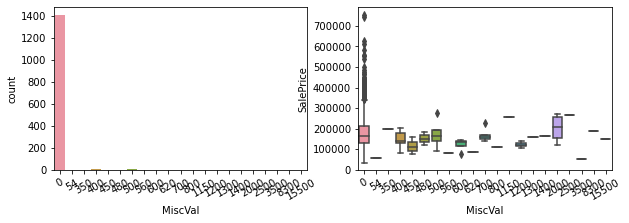

Признак LotArea имеет 0.0% пропущенных значений


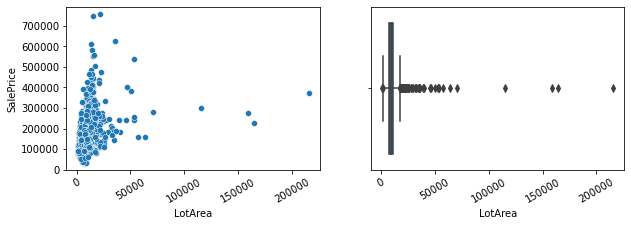

Признак YearBuilt имеет 0.0% пропущенных значений


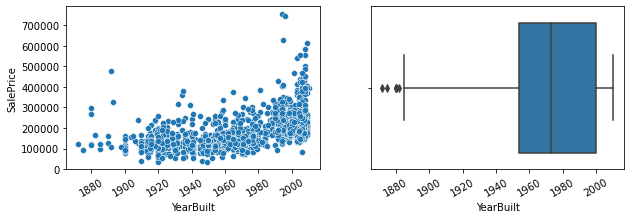

Признак YearRemodAdd имеет 0.0% пропущенных значений


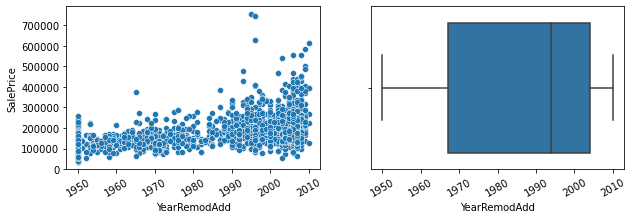

Признак TotalBsmtSF имеет 0.0% пропущенных значений


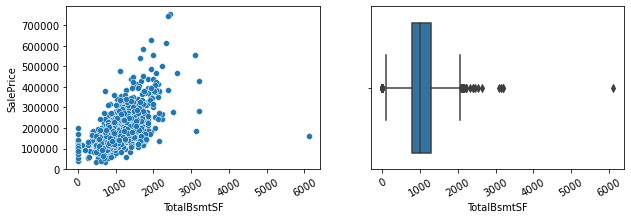

Признак GrLivArea имеет 0.0% пропущенных значений


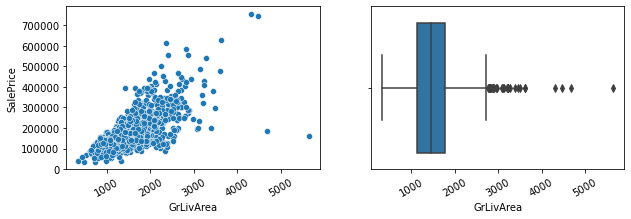

Признак GarageArea имеет 0.0% пропущенных значений


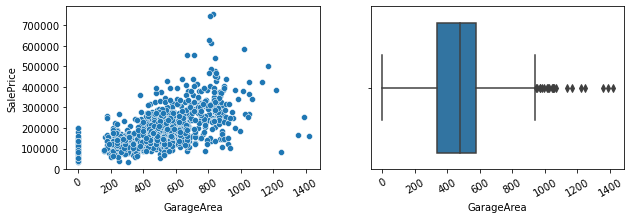

In [16]:
for c in categorial:
    cat_plot(c)
for nd in numerical_discr:
    cat_plot(nd)
for nc in numerical_cont:
    num_plot(nc)

1.	MSZoning
* Больше всего квартир в жилом районе с низкой плотностью населения, около 15% со средней плотностью, все остальные категории занимают менее 5% наблюдений. (Кстати по информационному файлу 8 категорий, а представлено всего 5)
* По отношению к результирующему признаку (SalePrice) Бокслоты могут помочь выявить выбросы.  Так, в районах с низкой и средней плотностью населения (самые часто встречаемые районы) наблюдается самый большой разброс цен (в случае квартир в районах с низкой плотностью цены выше 350 000 расцениваются как выбросы), вероятно это зависит и от других признаков, необходим комплексный анализ.

2.	Utilities
* В большинстве случаев в квартирах есть все блага, и ну оооочень мало квартир, где есть только электричество и газ.

3.	Condition1
* Более 80% наблюдений имеют значение Normal. Остальные категории встречаются заметно реже. Но удалять его не целесообразно, так как в кластеризации этот признак может сыграть свою роль.

4.	Condition2
* Для данного признака более 95% наблюдений имеют значение Normal. Остальные категории встречаются заметно реже. Что заставляет задуматься о целесообразности наличия признака.

5.	RoofStyle
* Тут более 75% - фронтон (если от этого стало как-то легче). Около 20% - Hip (что бы это ни было), а всё остальное менее 3%. 
* (Есть резон уменьшить количество категорий => объединить, так как одна категория, безусловно, доминирует, но суммарно остальные категории набирают около 25%). Нельзя (на наш взгляд) выкидывать.

6.	RoofMatl
* Более 95% домов имеют крышу с черепицей. Есть ли смысл в этом столбце? (нет)

7.	Exterior1st
* Материал из которого сделан дом. Около 35% домов - Vinyl Siding. Примерно одинаковое соотношение (около 15%) имеют Hard Board, Metal Siding и Wood Siding. Plywood занимает около 10% признака. Остальные категории занимают менее 5%.

8.	Exterior2nd
* Прошу обратить внимание на то, что данная и предыдущая картинка по двум последним признакам не сильно друг от друга отличаются... Однако отличия всё равно есть. Решено оставить этот признак.

9.	ExterQual
* Чаще всего в квартирах среднее (типичное) качество отделки. Около 35% имеют хорошую отделку и около 5% отличную, менее 5% - плохую. Признак хороший. Оставляем.

10.	ExterCond
* Состояние отделки. Около 85% - среднее состояние, около 10% -хорошее. (У меня только логический вопрос. А чем качество от состояния отличается?..

11.	Foundation
* Шлакоблок и бетон бились в схватке и выиграл бетон (оба встречаются примерно в 40% наблюдений).

12.	BsmtQual
* Высота подвала... Очень важный показатель... Ну допустим. Типичная высота подвала (80-89 дюймов) встречается чаще всего (около 45%), "хорошая" высота (90-99 дюймов) встречается чуть менее часто и т.д.. Прошу заметить, что NA (их 37 штук) для данного признака значит, что нет подвала в доме => NA может быть просто отдельной категорией признака. А Excellent и Fair нельзя объединять по смыслу.

13.	 BsmtCond
* Общее состояние подвала (на наш взгляд) несёт в себе больше связи с ценой, чем высота подвала, но возможно у статистики другое мнение... 
* В более чем 85% подвалов допускается небольшая влажность. С пропущенными значениями можно поступить так же, как было предложено в предыдущем пункте.

14. Heating
* Более чем в 95% квартир установлено газовое отопление. Убираем этот признак.

15.	HeatingQC
* Около 50% квартир имеют отличное качество и состояние отопления. Около 30% - среднее, менее 20% - хорошее. Признак вариативный. Оставляем.

16.	KitchenQual
* Качество кухни в основном среднее (Около 50% наблюдений имеют данную характеристику). 40% - хорошее состояние. 

17.	FireplaceQu
* Качество камина в основном хорошее. Около 40% - среднее от наблюдений, в которых есть данные. Однако стоит отметить, что больше половины признака – пропущенные значения. Можно закодировать их в будущем отдельной категорией, т.е. нет камина.

18.	GarageQual
* Около 90% наблюдений имеют среднее качество гаража. Так как оставшиеся категории – характеристика качества, то объединять их нельзя, а их в сумме наберется менее 200 штук. Есть смысл убрать из рассмотрения данный столбец.

19.	GarageCond
* Более 95% наблюдений имеют хорошее качество гаража. 

20.	PoolQC
* Данный признак имеет 99,62% наблюдений. Смысла его держать нет. Удаляем.

21.	 Fence
* Признак Fence имеет 80.75% пропущенных значений. Качество забора. Есть ли в этом логика? Насколько признак будет важен с таким количеством пропусков? Ответ лежит на поверхности.

22.	MiscFeature
* Признак MiscFeature имеет 96.3% пропущенных значений. Удалям.


Общий вывод по боксплотам для категориальный признаков по состоянию (качеству): Естественно, где квартиры имеют характеристику Excellent то усы и «тело» расположены выше остальных, аналогично расположение варьируется по смысловой нагрузке характеристики признака.

ПРОМЕЖУТОЧНЫЕ ИТОГИ: Из 22 категориальных признаков предложено удалить от 9 до 14.

23.	OverallQual
* Внезапно под численным признаком скрылся категориальный! Ну и как мы можем видеть, с увеличением общего качества и материала и отделки дома возрастает и стоимость. Есть смысл объединить категории.

24.	OverallCond
* Ещё одна внезапная категория под шапкой численного признака. Аналогичная история. Чаще всего дома оценивали в 5 (около 55% случаев), т.е среднее, однако именно тут самые большие цены (зависимость от других признаков).

25.	BedroomAbvGr
* Как мы поняли, это количество спален в лоте. Больше 5-ти можно считать за выбросы, так как даже при больших значениях стоимость квартиры всё равно не самая высокая. Однако необходимо исследовать это дополнительно

26.	 KitchenAbvGr
* Количество кухонь. В большинстве случаев (около 95%) в лоте всего 1 кухня. Есть смысл подумать над тем, чтобы убрать этот столбец, так как остальные случаи можно воспринимать как выбросы.

27.	TotRmsAbvGrd
* Общее количество комнат (без ванных комнат). Есть дворец, где 14 комнат (и с довольно небольшой стоимостью – выброс?). Чем больше комнат – тем выше цена. Логично.

28.	Fireplaces
* Дома, где более 3-ёх каминов – выброс? (таких всего 5 и цена их невысокая). Чем больше каминов, тем выше цена. Вероятно связано с тем, что там больше площадь. 

29.	PoolArea
* Тут целое море нулей. Убираем этот столбец. ВСЕГО 7 НАБЛЮДЕНИЙ НЕ РАВНО 0.

30.	MiscVal
* Тут опять же море и маленькая лужа нулей. Удаляем.

31. LotArea
* Размер квартиры в квадратных фунтах. В основном все наблюдения сконцентрированы в одном облаке, но есть прям огромные дворцы. Есть вероятность того, что это очепятка, так как эти лоты стоят не сильно дороже остальных. В любом случае необходимо дополнительное исследование на выбросы

32.	YearBuilt
* По логике можно преобразовать данные в количество лет дому например. Мы можем отчетливо увидеть связь. Чем новее дом, тем выше цена. Хотя опять же не без выбросов не обошлось. В основном дома 20-21 века. В периоды воин (первой и второй мировой) дома как-то не возводили…

33. YearRemodAdd
* Дата реконструкции (такая же, как и дата строительства, если не было реконструкции или дополнений). Все реконструкции начались с 1950-го года. Чем «свежее» реконструкция, тем выше цена в основном.

34. TotalBsmtSF
* Общая площадь подвала в квадратных футах. Есть один какой-то ультра бункер. Чем больше площадь подвала, тем выше цена. Без выбросов не обошлось.

35.	GrLivArea
* Квадратные фунты жилой площади над уровнем моря. Опять же есть выбросы. Опять же, чем больше жилая площадь, тем выше цена. 

36.	GarageArea
* Размер гаража в квадратных футах.  Все лоты, где гараж имеет площадь более 1000 фунтов расцениваются боксплотом как выбросы. Логично. Больше площадь гаража – больше стоимость лота.

ОБЩИЙ ВЫВОД:
Из 36 признаков можно убрать от 9 до 14 штук. Неплохое уменьшение размерности без метода главных компонент) 

Составим список признаков, у которых более 89% строк содержат одно и то же значение. Данные признаки несут в себе мало полезной информации, которая может сыграть важную роль при кластеризации, поэтому их можно убрать из датасета.

In [17]:
low_information_cols = []

for col in df.columns:
    val = df[col].value_counts(dropna=False)
    top = (val/(len(df))).iloc[0]
    if top > 0.89:
        low_information_cols.append(col)
        print('{0}: {1:.5f}%'.format(col, top*100))
        print(val)
        print()

Utilities: 99.93151%
AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64

Condition2: 98.97260%
Norm      1445
Feedr        6
Artery       2
RRNn         2
PosN         2
PosA         1
RRAe         1
RRAn         1
Name: Condition2, dtype: int64

RoofMatl: 98.21918%
CompShg    1434
Tar&Grv      11
WdShngl       6
WdShake       5
Roll          1
ClyTile       1
Membran       1
Metal         1
Name: RoofMatl, dtype: int64

BsmtCond: 89.79452%
TA     1311
Gd       65
Fa       45
NaN      37
Po        2
Name: BsmtCond, dtype: int64

Heating: 97.80822%
GasA     1428
GasW       18
Grav        7
Wall        4
OthW        2
Floor       1
Name: Heating, dtype: int64

KitchenAbvGr: 95.34247%
1    1392
2      65
3       2
0       1
Name: KitchenAbvGr, dtype: int64

GarageQual: 89.79452%
TA     1311
NaN      81
Fa       48
Gd       14
Po        3
Ex        3
Name: GarageQual, dtype: int64

GarageCond: 90.82192%
TA     1326
NaN      81
Fa       35
Gd        9
Po        7
Ex        2
Name: 

Рассмотрим распределение числовых признаков:

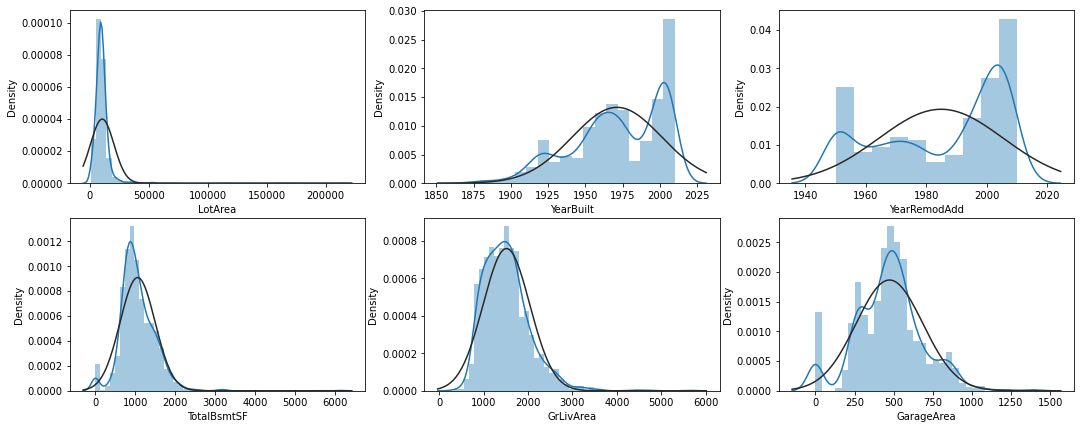

In [18]:
f, ax = plt.subplots(2, 3, figsize=(18, 7))
for i, c in enumerate(numerical_cont):
    sns.distplot(df[c], fit=norm, ax=ax[i//3, i%3])

Попробуем исправить положение логарифмированием от признака + 1:

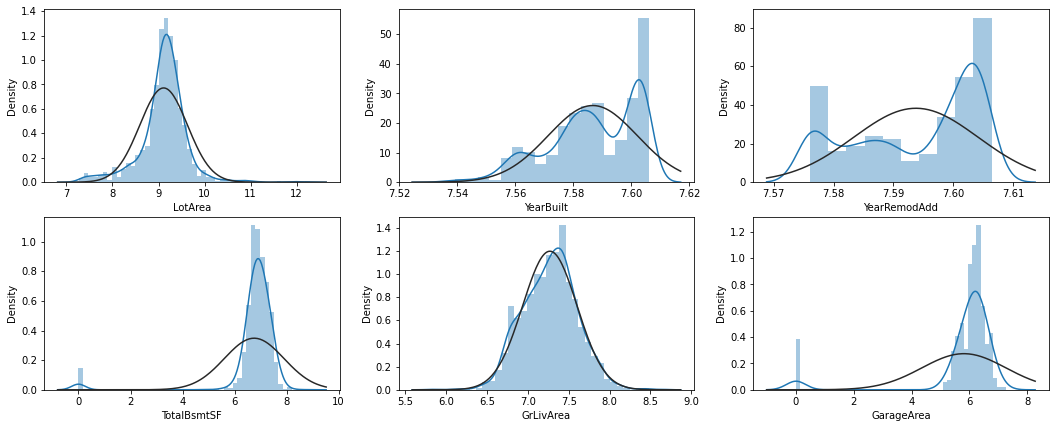

In [19]:
f, ax = plt.subplots(2, 3, figsize=(18, 7))
for i, c in enumerate(numerical_cont):
    sns.distplot(np.log1p(df[c]), fit=norm, ax=ax[i//3, i%3])

Как  видно из графиков, положение заметно улучшилось у жилой площади. Запомним это.

#### Тут хорошо бы попроверять разные гипотезы про признаки, например

In [20]:
alpha = 0.05

**H0:** признаки Condition1 (расположенный рядом объект) и Condition2 (еще один расположенный рядом объект, если их больше 1)  принадлежат одному и тому же распределению.

In [21]:
stat, p = stats.mannwhitneyu(df['Condition1'], df['Condition2'])
print('Statistics=%.3f, p-value=%.3f' % (stat, p))
if p > alpha:
    print(f'H0 не отклоняется с вероятностью {1-alpha}')
else:
    print(f'H0 отклоняется с вероятностью {1-alpha}')

Statistics=1024283.500, p-value=0.000
H0 отклоняется с вероятностью 0.95


**H0:** признак TotalBsmtSF (общая площадь подвала) распределен нормально.

In [22]:
stat, p = stats.kstest(df['TotalBsmtSF'], 'norm')
print('Statistics=%.3f, p-value=%.3f' % (stat, p))
if p > alpha:
    print(f'H0 не отклоняется с вероятностью {1-alpha}')
else:
    print(f'H0 отклоняется с вероятностью {1-alpha}')

Statistics=0.975, p-value=0.000
H0 отклоняется с вероятностью 0.95


**H0:** медианы признаков LotArea (общая площадь) и GrLivArea (жилая площадь) равны.

In [23]:
stat, p = stats.kruskal(df['LotArea'], df['GrLivArea'])
print('Statistics=%.3f, p-value=%.3f' % (stat, p))
if p > alpha:
    print(f'H0 не отклоняется с вероятностью {1-alpha}')
else:
    print(f'H0 отклоняется с вероятностью {1-alpha}')

Statistics=2128.013, p-value=0.000
H0 отклоняется с вероятностью 0.95


### 1.1. Выводы по обзору данных

Стоит обмолвиться, что, исходя из боксплотов, выбросы присутствуют в признаках, но к ним вернемся позже.

Признаки MiscFeature, PoolQC, Fence и FireplaceQu содержат слишком много пропусков. Помимо этого, признаки, у которых более 89% строк содержат одинаковое значение, можно удалить без особых потерь для информативности данных в целом.

Удаляем эти признаки из датасета.

In [24]:
delete_cols = list(set(low_information_cols + ['MiscFeature', 'PoolQC', 'Fence', 'FireplaceQu']))
df = df.drop(delete_cols, axis=1)
df

,SalePrice,MSZoning,LotArea,Condition1,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,Exterior1st,...,Foundation,BsmtQual,TotalBsmtSF,HeatingQC,GrLivArea,BedroomAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,GarageArea
0,208500,RL,8450,Norm,7,5,2003,2003,Gable,VinylSd,...,PConc,Gd,856,Ex,1710,3,Gd,8,0,548
1,181500,RL,9600,Feedr,6,8,1976,1976,Gable,MetalSd,...,CBlock,Gd,1262,Ex,1262,3,TA,6,1,460
2,223500,RL,11250,Norm,7,5,2001,2002,Gable,VinylSd,...,PConc,Gd,920,Ex,1786,3,Gd,6,1,608
3,140000,RL,9550,Norm,7,5,1915,1970,Gable,Wd Sdng,...,BrkTil,TA,756,Gd,1717,3,Gd,7,1,642
4,250000,RL,14260,Norm,8,5,2000,2000,Gable,VinylSd,...,PConc,Gd,1145,Ex,2198,4,Gd,9,1,836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,175000,RL,7917,Norm,6,5,1999,2000,Gable,VinylSd,...,PConc,Gd,953,Ex,1647,3,TA,7,1,460
1456,210000,RL,13175,Norm,6,6,1978,1988,Gable,Plywood,...,CBlock,Gd,1542,TA,2073,3,TA,7,2,500
1457,266500,RL,9042,Norm,7,9,1941,2006,Gable,CemntBd,...,Stone,TA,1152,Ex,2340,4,Gd,9,2,252
1458,142125,RL,9717,Norm,5,6,1950,1996,Hip,MetalSd,...,CBlock,TA,1078,Gd,1078,2,Gd,5,0,240


Таким образом, в датасете осталось 23 "хороших" признака, один из которых результирующий. Обновляем переменные после удаления признаков из исходного датасета.

In [25]:
numerical_discr = [f for f in df.columns if df.dtypes[f] != 'object' and f != 'SalePrice' and df[f].nunique() <= 22]
numerical_cont = [f for f in df.columns if df.dtypes[f] != 'object' and f != 'SalePrice' and df[f].nunique() > 22]
numerical = numerical_cont + numerical_discr
categorial = [f for f in df.columns if df.dtypes[f] == 'object'] 

### 1.2. Теперь подробнее изучим результирующий признак SalePrice.

Как ранее показала проверка, пропуски в SalePrice отсутствуют.

In [26]:
print(f"Количество пропусков в SalePrice: {df['SalePrice'].isnull().sum()}")

Количество пропусков в SalePrice: 0


Проверим гипотезу о нормальности распределения SalePrice.

* **H0:** признак имеет гауссово распределение.
* **H1:** признак не имеет гауссовского распределения.

In [27]:
stat, p = stats.kstest(df['SalePrice'], 'norm')
print('Statistics=%.3f, p-value=%.3f' % (stat, p))
if p > alpha:
    print(f'H0 не отклоняется с вероятностью {1-alpha}')
else:
    print(f'H0 отклоняется с вероятностью {1-alpha}')

Statistics=1.000, p-value=0.000
H0 отклоняется с вероятностью 0.95


In [28]:
stat, p = stats.normaltest(df['SalePrice'])
print('Statistics=%.3f, p-value=%.3f' % (stat, p))
if p > alpha:
    print(f'H0 не отклоняется с вероятностью {1-alpha}')
else:
    print(f'H0 отклоняется с вероятностью {1-alpha}')

Statistics=610.836, p-value=0.000
H0 отклоняется с вероятностью 0.95


In [29]:
stat, p = stats.shapiro(df['SalePrice'])
print('Statistics=%.3f, p-value=%.3f' % (stat, p))
if p > alpha:
    print(f'H0 не отклоняется с вероятностью {1-alpha}')
else:
    print(f'H0 отклоняется с вероятностью {1-alpha}')

Statistics=0.870, p-value=0.000
H0 отклоняется с вероятностью 0.95


Посмотрим на распределение SalePrice.

Ассимметрия: 1.883
Эксцесс: 6.536


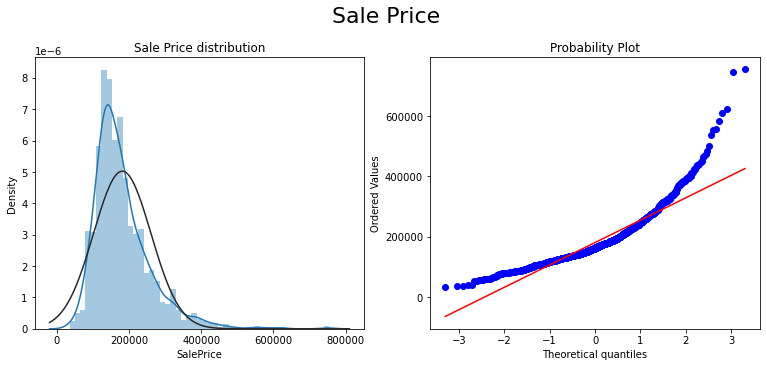

In [30]:
print(f"Ассимметрия: {round(df['SalePrice'].skew(), 3)}")
print(f"Эксцесс: {round(df['SalePrice'].kurt(), 3)}")
f, ax = plt.subplots(1, 2, figsize=(13, 5))
sns.distplot(df['SalePrice'], fit=norm, ax=ax[0])
ax[0].set_title('Sale Price distribution')
probplot(df['SalePrice'], plot=ax[1])
plt.suptitle('Sale Price', fontsize=22,  y=1.02)
plt.show()

Поскольку гистограмма смещена влево (асимметрия > 0), а точки графика QQ находятся вне базовой линии, для соответствия нормальности необходимо преобразование (например, логарифмическое преобразование).

In [31]:
print('Преобразуем SalePrice в логарифм от SalePrice + 1.' if (df.SalePrice == 0).sum() > 0 else 'Преобразуем SalePrice в логарифм от SalePrice.')

Преобразуем SalePrice в логарифм от SalePrice.


Ассимметрия: 0.121
Эксцесс: 0.81


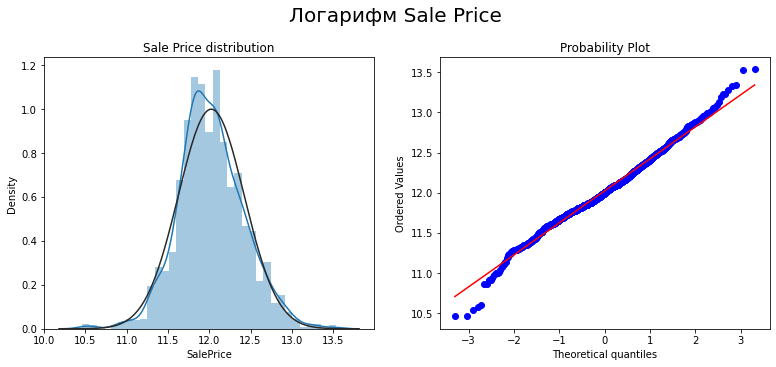

In [32]:
print(f"Ассимметрия: {round(np.log(df['SalePrice']).skew(), 3)}")
print(f"Эксцесс: {round(np.log(df['SalePrice']).kurt(), 3)}")
f, ax = plt.subplots(1, 2, figsize=(13, 5))
sns.distplot(np.log(df['SalePrice']), fit=norm, ax=ax[0])
ax[0].set_title('Sale Price distribution')
probplot(np.log(df['SalePrice']), plot=ax[1])
plt.suptitle('Логарифм Sale Price', fontsize=20, y=1.02)
plt.show()

Распределение стало больше похоже на нормальное.

In [33]:
print(f'Минимальная цена продажи: {df.SalePrice.min()}')
print(f'Максимальная цена продажи: {df.SalePrice.max()}')
print(f'Средняя цена продажи: {round(df.SalePrice.mean())}')

Минимальная цена продажи: 34900
Максимальная цена продажи: 755000
Средняя цена продажи: 180921


## 2. Работа с выбросами

было принято решение обработать выбросы с помощью DBSCAN. Но тут появляется вопрос о значениях эпсилон и соседях. Для начала подберём оптимальный эпсилон (самое дальнее расстояние, на котором точка "выбирает" своих соседей):

In [34]:
X = StandardScaler().fit_transform(df[numerical].values)

Методом проб и ошибок выяснила, что лучше всего очищение от выбросов происходит при поиске 20-ти ближайших соседей. Построим график изменения расстояния.

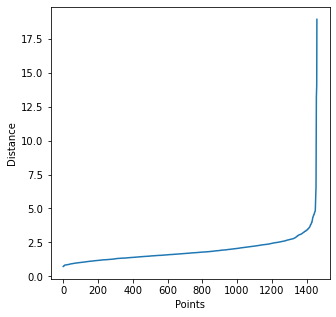

In [35]:
nearest_neighbors = NearestNeighbors(n_neighbors=21)
neighbors = nearest_neighbors.fit(X)
distances, indices = neighbors.kneighbors(X)

distances = np.sort(distances[:, 20], axis=0)
i = np.arange(len(distances))
knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')

fig = plt.figure(figsize=(5, 5))
plt.plot(distances)
plt.xlabel("Points")
plt.ylabel("Distance");

plt.savefig("Distance_curve.png", dpi=300)

Далее изобразим на графике место излома и выведем оптимальное расстояние (значение эпсилон)

2.7322117756674116


<Figure size 360x360 with 0 Axes>

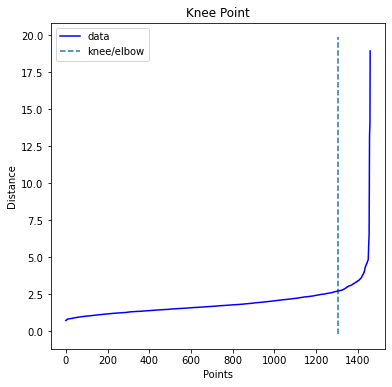

In [36]:
fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")
plt.savefig("knee.png", dpi=300)
print(distances[knee.knee])

Воспользуемся полученными значениями параметров и реализуем очищение от выбросов:

In [37]:
db = DBSCAN(eps=distances[knee.knee], min_samples=20).fit(X)
labels = db.labels_

In [38]:
pd.Series(labels).value_counts()

 0    1409
-1      51
dtype: int64

DBSCAN определил 51 точку как выбросы. Посмотрим на них поближе:

In [39]:
df['Outliers'] = labels
df[df['Outliers'] == -1]

,SalePrice,MSZoning,LotArea,Condition1,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,Exterior1st,...,BsmtQual,TotalBsmtSF,HeatingQC,GrLivArea,BedroomAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,GarageArea,Outliers
53,385000,RL,50271,Norm,9,5,1981,1987,Gable,WdShing,...,Ex,1842,Gd,1842,0,Gd,5,1,894,-1
144,125000,RM,9100,RRAe,5,5,1963,1963,Gable,HdBoard,...,TA,1728,TA,1728,6,TA,10,0,504,-1
185,475000,RM,22950,Artery,10,9,1892,1993,Gable,Wd Sdng,...,TA,1107,Ex,3608,4,Ex,12,2,840,-1
197,235000,RL,25419,Artery,8,4,1918,1990,Gable,Stucco,...,TA,1360,Gd,3112,4,Gd,8,1,795,-1
249,277000,RL,159000,Norm,6,7,1958,2006,Gable,Wd Sdng,...,Gd,1444,Gd,2144,4,Gd,7,2,389,-1
271,241500,RL,39104,Norm,7,7,1954,2005,Flat,Plywood,...,Gd,1385,Ex,1363,2,TA,5,2,439,-1
291,135900,RL,5687,Norm,5,6,1912,2000,Gable,VinylSd,...,TA,780,Ex,1716,6,Fa,9,0,0,-1
304,295000,RM,18386,Norm,7,9,1880,2002,Gable,CemntBd,...,TA,1470,Ex,3493,3,Gd,10,1,870,-1
313,375000,RL,215245,Norm,7,5,1965,1965,Hip,BrkFace,...,Gd,2136,TA,2036,3,TA,8,2,513,-1
330,119000,RL,10624,Norm,5,4,1964,1964,Gable,HdBoard,...,TA,1728,TA,1728,6,TA,10,0,352,-1


Удалим их из данных.

In [40]:
df = df[df['Outliers']==0]
df.index = pd.RangeIndex(0, len(df))
df

,SalePrice,MSZoning,LotArea,Condition1,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,Exterior1st,...,BsmtQual,TotalBsmtSF,HeatingQC,GrLivArea,BedroomAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,GarageArea,Outliers
0,208500,RL,8450,Norm,7,5,2003,2003,Gable,VinylSd,...,Gd,856,Ex,1710,3,Gd,8,0,548,0
1,181500,RL,9600,Feedr,6,8,1976,1976,Gable,MetalSd,...,Gd,1262,Ex,1262,3,TA,6,1,460,0
2,223500,RL,11250,Norm,7,5,2001,2002,Gable,VinylSd,...,Gd,920,Ex,1786,3,Gd,6,1,608,0
3,140000,RL,9550,Norm,7,5,1915,1970,Gable,Wd Sdng,...,TA,756,Gd,1717,3,Gd,7,1,642,0
4,250000,RL,14260,Norm,8,5,2000,2000,Gable,VinylSd,...,Gd,1145,Ex,2198,4,Gd,9,1,836,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1404,175000,RL,7917,Norm,6,5,1999,2000,Gable,VinylSd,...,Gd,953,Ex,1647,3,TA,7,1,460,0
1405,210000,RL,13175,Norm,6,6,1978,1988,Gable,Plywood,...,Gd,1542,TA,2073,3,TA,7,2,500,0
1406,266500,RL,9042,Norm,7,9,1941,2006,Gable,CemntBd,...,TA,1152,Ex,2340,4,Gd,9,2,252,0
1407,142125,RL,9717,Norm,5,6,1950,1996,Hip,MetalSd,...,TA,1078,Gd,1078,2,Gd,5,0,240,0


Таким образом, "в живых" у нас осталось 1409 наблюдений, посмотрим изменения на графиков для наших признаков (в том числе изменения распределения):

Признак MSZoning имеет 0.0% пропущенных значений


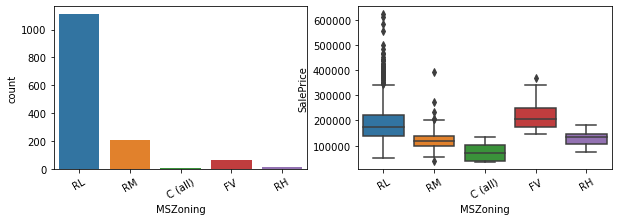

Признак Condition1 имеет 0.0% пропущенных значений


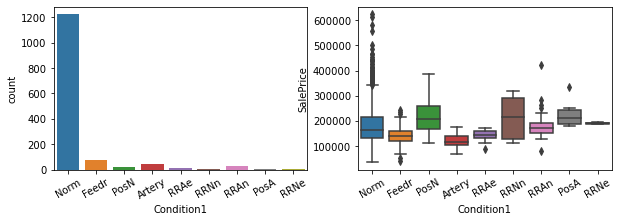

Признак RoofStyle имеет 0.0% пропущенных значений


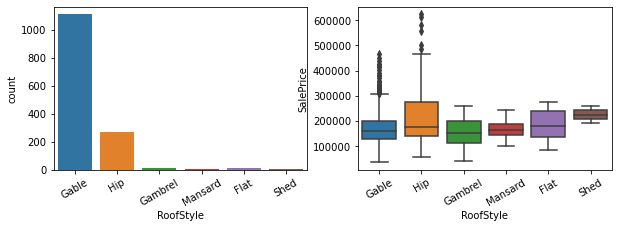

Признак Exterior1st имеет 0.0% пропущенных значений


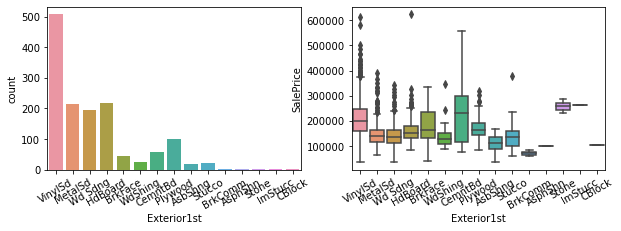

Признак Exterior2nd имеет 0.0% пропущенных значений


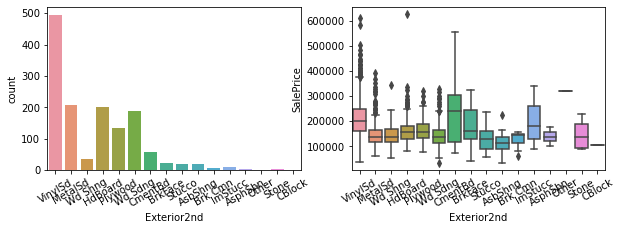

Признак ExterQual имеет 0.0% пропущенных значений


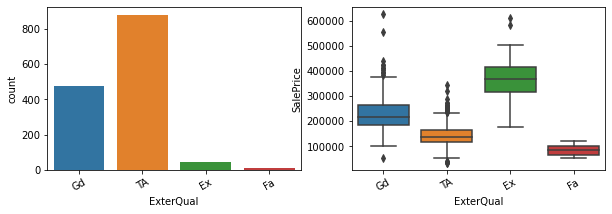

Признак ExterCond имеет 0.0% пропущенных значений


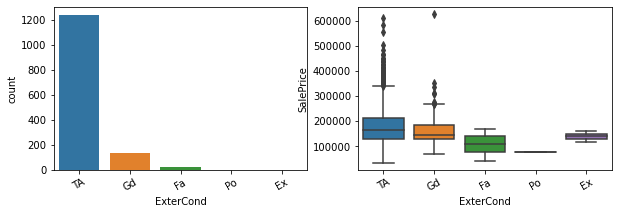

Признак Foundation имеет 0.0% пропущенных значений


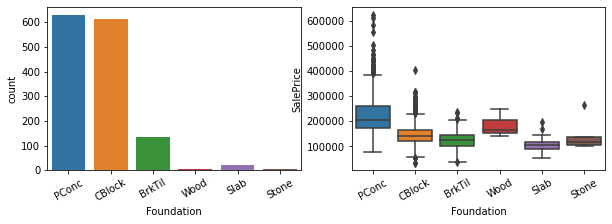

Признак BsmtQual имеет 2.48% пропущенных значений


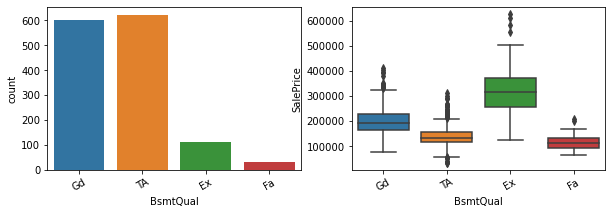

Признак HeatingQC имеет 0.0% пропущенных значений


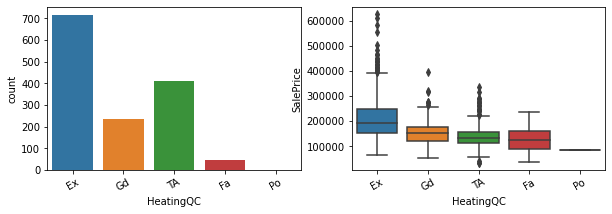

Признак KitchenQual имеет 0.0% пропущенных значений


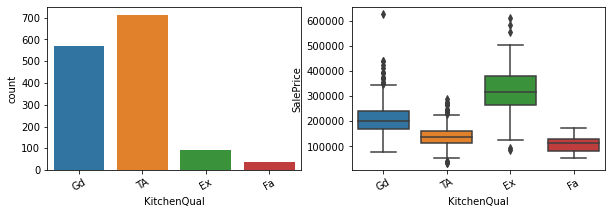

Признак OverallQual имеет 0.0% пропущенных значений


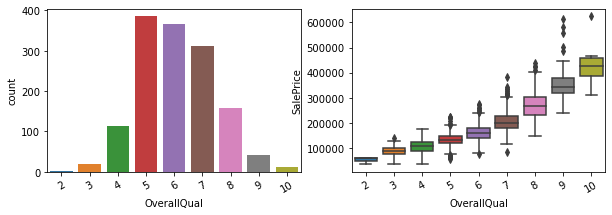

Признак OverallCond имеет 0.0% пропущенных значений


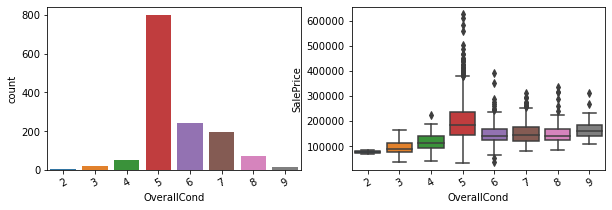

Признак BedroomAbvGr имеет 0.0% пропущенных значений


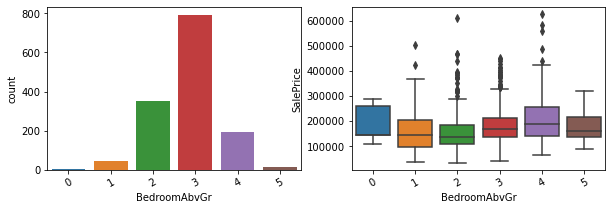

Признак TotRmsAbvGrd имеет 0.0% пропущенных значений


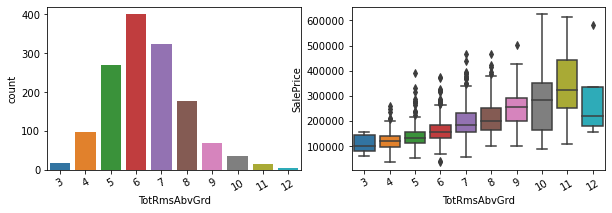

Признак Fireplaces имеет 0.0% пропущенных значений


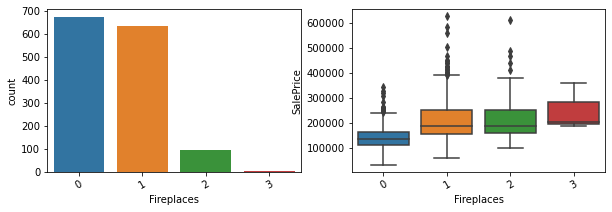

Признак LotArea имеет 0.0% пропущенных значений


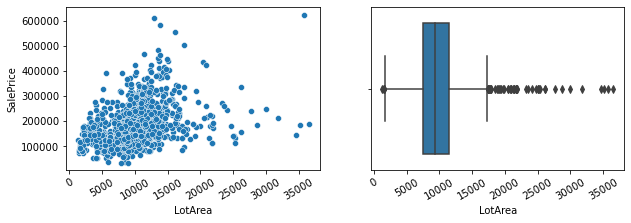

Признак YearBuilt имеет 0.0% пропущенных значений


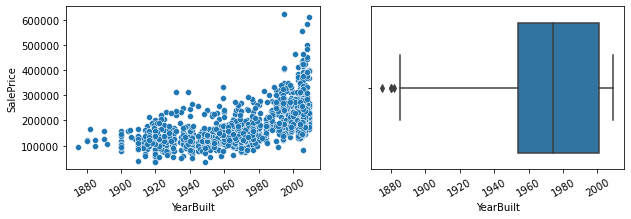

Признак YearRemodAdd имеет 0.0% пропущенных значений


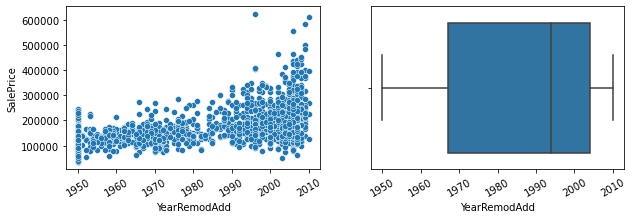

Признак TotalBsmtSF имеет 0.0% пропущенных значений


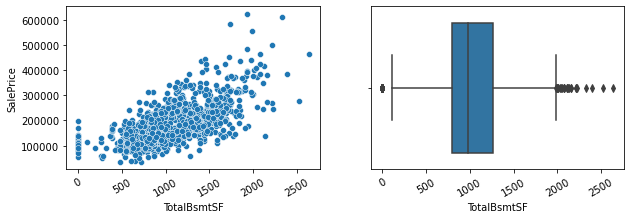

Признак GrLivArea имеет 0.0% пропущенных значений


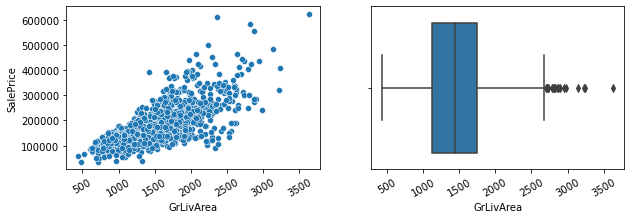

Признак GarageArea имеет 0.0% пропущенных значений


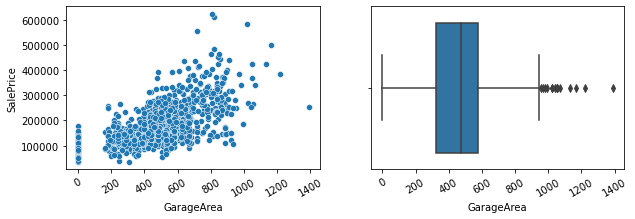

In [41]:
for c in categorial:
    cat_plot(c)
for nd in numerical_discr:
    cat_plot(nd)
for nc in numerical_cont:
    num_plot(nc)

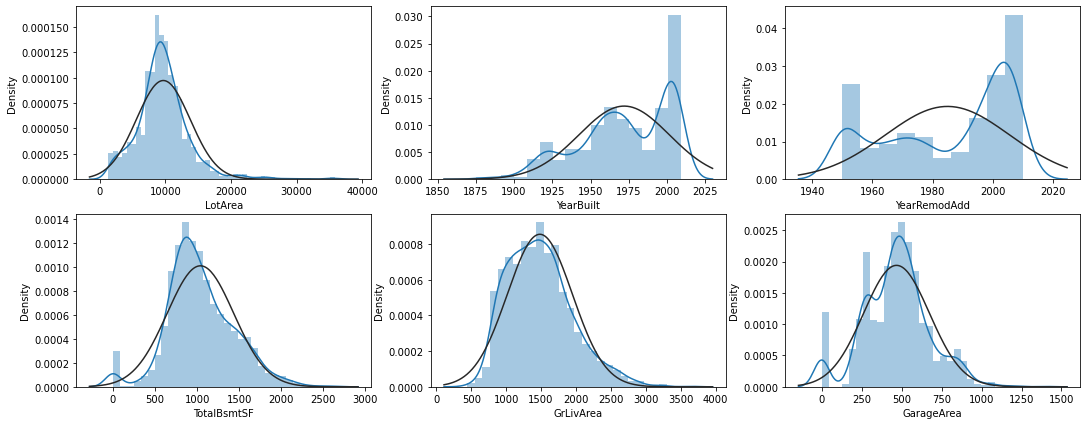

In [42]:
f, ax = plt.subplots(2, 3, figsize=(18, 7))
for i, c in enumerate(numerical_cont):
    sns.distplot(df[c], fit=norm, ax=ax[i//3, i%3])

И с логарифмированием от признака + 1:

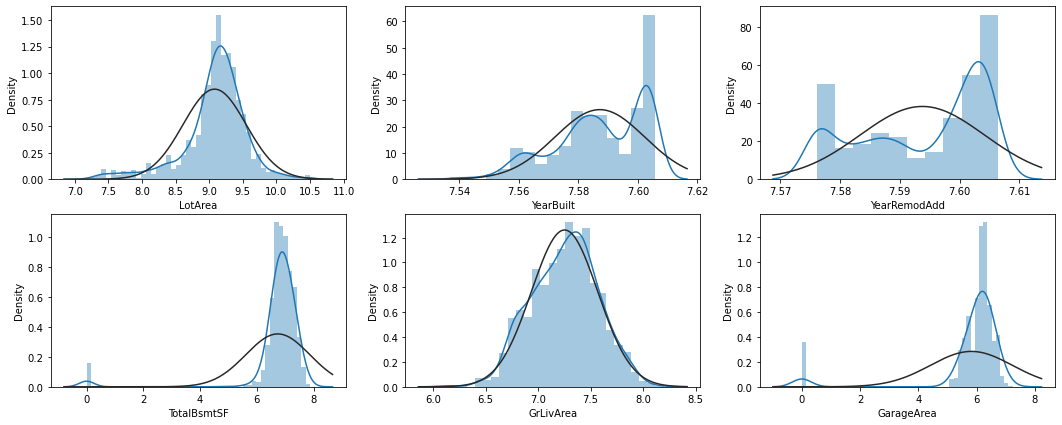

In [43]:
f, ax = plt.subplots(2, 3, figsize=(18, 7))
for i, c in enumerate(numerical_cont):
    sns.distplot(np.log1p(df[c]), fit=norm, ax=ax[i//3, i%3])

Очевидно, что ситуация заметно улучшилась по сравнению с графиками, которые мы строили при обзоре данных. Экспериментально было доказано, что уменьние количества соседей (то есть правило отбора ужесточается => больше наблюдений считаются выбросами) в целом не сильно улучшают картину с боксплотами, но "съедаются" наблюдения, которые можно оставить. Данные после обработки выбросов выглядят следующим образом:

In [44]:
df = df.drop(['Outliers'], axis=1)
df

,SalePrice,MSZoning,LotArea,Condition1,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,Exterior1st,...,Foundation,BsmtQual,TotalBsmtSF,HeatingQC,GrLivArea,BedroomAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,GarageArea
0,208500,RL,8450,Norm,7,5,2003,2003,Gable,VinylSd,...,PConc,Gd,856,Ex,1710,3,Gd,8,0,548
1,181500,RL,9600,Feedr,6,8,1976,1976,Gable,MetalSd,...,CBlock,Gd,1262,Ex,1262,3,TA,6,1,460
2,223500,RL,11250,Norm,7,5,2001,2002,Gable,VinylSd,...,PConc,Gd,920,Ex,1786,3,Gd,6,1,608
3,140000,RL,9550,Norm,7,5,1915,1970,Gable,Wd Sdng,...,BrkTil,TA,756,Gd,1717,3,Gd,7,1,642
4,250000,RL,14260,Norm,8,5,2000,2000,Gable,VinylSd,...,PConc,Gd,1145,Ex,2198,4,Gd,9,1,836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1404,175000,RL,7917,Norm,6,5,1999,2000,Gable,VinylSd,...,PConc,Gd,953,Ex,1647,3,TA,7,1,460
1405,210000,RL,13175,Norm,6,6,1978,1988,Gable,Plywood,...,CBlock,Gd,1542,TA,2073,3,TA,7,2,500
1406,266500,RL,9042,Norm,7,9,1941,2006,Gable,CemntBd,...,Stone,TA,1152,Ex,2340,4,Gd,9,2,252
1407,142125,RL,9717,Norm,5,6,1950,1996,Hip,MetalSd,...,CBlock,TA,1078,Gd,1078,2,Gd,5,0,240


Осталось 23 признака и 1409 наблюдений. Отличный боевой набор. Посмотрим, насколько чистка выбросов повлияла на результирующий признак:

Ассимметрия: 0.066
Эксцесс: 0.683


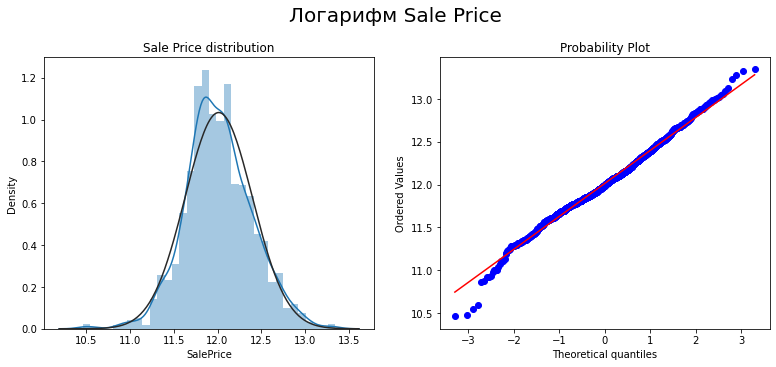

In [45]:
print(f"Ассимметрия: {round(np.log(df['SalePrice']).skew(), 3)}")
print(f"Эксцесс: {round(np.log(df['SalePrice']).kurt(), 3)}")
f, ax = plt.subplots(1, 2, figsize=(13, 5))
sns.distplot(np.log(df['SalePrice']), fit=norm, ax=ax[0])
ax[0].set_title('Sale Price distribution')
probplot(np.log(df['SalePrice']), plot=ax[1])
plt.suptitle('Логарифм Sale Price', fontsize=20, y=1.02)
plt.show()

Ситуация стала ещё лучше. Значение эксцесса и ассимметрии снизилось.

#### Маленький разговор про оставшиеся пропуски.

In [46]:
df.isnull().sum()[df.isnull().sum() > 0].sort_values()

BsmtQual    35
dtype: int64

Признак BsmtQual – качество подвала - явно связан с признаком TotalBsmtSF – общая площадь подвала. Посмотрим на TotalBsmtSF еще раз.

Признак TotalBsmtSF имеет 0.0% пропущенных значений


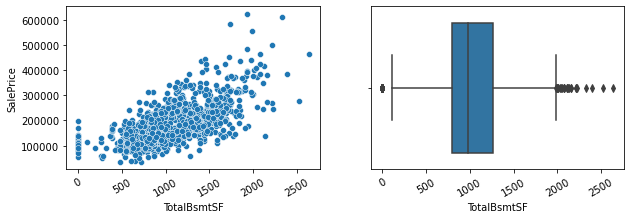

In [47]:
num_plot('TotalBsmtSF')

Проверим, являются ли причиной пропусков в признаке BsmtQual нулевые значения признака TotalBsmtSF, то есть, отсутствие подвала.

In [48]:
df[df['TotalBsmtSF'] == 0]['BsmtQual'].all(None) == df[df['BsmtQual'] == None]['TotalBsmtSF'].all(0)

True

Таким образом, данные пропуски можно заполнить новой категорией - отсутствие подвала. 

## 3. Обработка признаков 

Прежде чем строить Пайплайны с поэтапным преобразованием данных нужно собрать все "выжившие" признаки в одну кучу, чтобы понять, как именно их стоит группировать между собой для комплексного изменения, чтобы не разводить море пайплайнов для каждого признака отдельно.

Раз уж в конце предыдущего раздела мы завели разговор про заполнение пропусков, тогда начнём именно с этого признака и заодно рассмотрим способы кодирования категориальных данных.

Итак, признак BsmtQual (качество подвала) имеет внутри 35 пропущенных значений, и как было доказано ранее, эти пропуски означают отсутствие подвала. Соответственно эти пропуски мы заполним новой категорией - NB (No Basement).

Этот признак можно отнести к определённому подразделу категориальных переменных в этом датасете - категории качества (ExterQual, ExterCond, HeatingQC, KitchenQual). То есть эти признаки содержат в себе следующие категории:  Ex	- Excellent, Gd - Good, TA - Average/Typical, Fa - Fair, Po - Poor. Таким образом, исходя из логики, мы можем каждому значению категории присвоить определённый "балл" качества. Например, NB = 0, Po = 1, Fa = 2, TA = 3, Gd = 4, Ex = 5. Структура и смысл категорий сохранён

Тогда словари, содержащие в себе правило присваивания числовых значений, выглядят следующим образом:

In [49]:
Quality_sorted = {'Fa': 2, 'TA': 3,'Gd': 4, 'Ex': 5}
Quality_sorted0 = {'Po': 1, 'Fa': 2, 'TA': 3,'Gd': 4, 'Ex': 5}

Ну и так как нам в любом случае данные надо стандартизировать, то процесс преобразования выглядит следующим образом:

In [50]:
pipe_steps = [
    ('category_quality', OrdinalEncoder(mapping=[{'col': 'BsmtQual', 'mapping': Quality_sorted},
                                                 {'col': 'ExterQual', 'mapping': Quality_sorted},
                                                {'col': 'KitchenQual', 'mapping': Quality_sorted},
                                                {'col': 'ExterCond', 'mapping': Quality_sorted0},
                                                {'col': 'HeatingQC', 'mapping': Quality_sorted0},])),
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler())
]

pipe = Pipeline(steps=pipe_steps)

In [51]:
pipe.fit(df[['BsmtQual','ExterQual','KitchenQual','ExterCond','HeatingQC']]);

In [52]:
pipe.transform(df[['BsmtQual','ExterQual','KitchenQual','ExterCond','HeatingQC']])

array([[ 0.54592777,  1.07834617,  0.75235564, -0.24244552,  0.8885124 ],
       [ 0.54592777, -0.69871787, -0.77732559, -0.24244552,  0.8885124 ],
       [ 0.54592777,  1.07834617,  0.75235564, -0.24244552,  0.8885124 ],
       ...,
       [-0.47696083,  2.85541021,  0.75235564,  2.67726169,  0.8885124 ],
       [-0.47696083, -0.69871787,  0.75235564, -0.24244552, -0.15736393],
       [-0.47696083,  1.07834617, -0.77732559, -0.24244552, -0.15736393]])

Теперь же поговорим о другой проблеме обработки данных - кодировка категориальных признаков, где множество разнообразных категорий (MSZoning, Condition1, RoofStyle, Exterior1st, Exterior2nd, Foundation). Рашила остановиться на TargetEncoder. В конце проводим стандартизацию (как и всегда).

In [53]:
pipe_steps1 = [
    ('encoder_category', TargetEncoder()),
    ('scaler', StandardScaler())
]

pipe1 = Pipeline(steps=pipe_steps1)

In [54]:
pipe1.fit(df[['MSZoning', 'Condition1', 'RoofStyle','Exterior1st', 'Exterior2nd', 'Foundation']],df['SalePrice']);

In [55]:
pipe1.transform(df[['MSZoning', 'Condition1', 'RoofStyle','Exterior1st', 'Exterior2nd', 'Foundation']])

array([[ 0.37615931,  0.22819907, -0.48914544,  1.09955232,  1.12024225,
         1.09170994],
       [ 0.37615931, -2.45079881, -0.48914544, -0.9116741 , -0.88660564,
        -0.76578459],
       [ 0.37615931,  0.22819907, -0.48914544,  1.09955232,  1.12024225,
         1.09170994],
       ...,
       [ 0.37615931,  0.22819907, -0.48914544,  1.53140558,  1.63155935,
        -0.7756834 ],
       [ 0.37615931,  0.22819907,  2.02393241, -0.9116741 , -0.88660564,
        -0.76578459],
       [ 0.37615931,  0.22819907, -0.48914544, -0.55676754, -0.42364584,
        -0.76578459]])

Осталось поговорить про числовые признаки.

Как показал разведочный анализ ранее, в наборе данных существуют "псевдочисленные" признаки, которые на самом деле обозначают качество. Это признаки OverallQual, OverallCond. По сути это уже готовое кодирование категориальных данных, поэтому нам остаётся только их стандартизировать. 

Аналогично только стандартизацию проведём для BedroomAbvGr, TotRmsAbvGrd, Fireplaces, LotArea, YearBuilt, YearRemodAdd, TotalBsmtSF и GarageArea. 

Однако разведочный анализ показал, что логарифмирование GrLivArea и SalePrice имеет смысл, так как это приближает распределение данных к нормальному виду. 

In [56]:
pipe_steps2 = [
    ('log', FunctionTransformer(func=np.log, inverse_func=np.exp)),
    ('scaler', StandardScaler())
]

pipe2 = Pipeline(steps=pipe_steps2)

In [57]:
pipe2.fit(df[['GrLivArea', 'SalePrice']]);

In [58]:
pipe2.transform(df[['GrLivArea', 'SalePrice']])

array([[ 0.6072002 ,  0.60703517],
       [-0.35243806,  0.2475165 ],
       [ 0.74456221,  0.78713327],
       ...,
       [ 1.59799067,  1.24329405],
       [-0.85023878, -0.38644425],
       [-0.36749207, -0.2902123 ]])

Собираем всё вместе:

In [59]:
transformer = ColumnTransformer(
    [('category', Pipeline(steps=pipe_steps), ['BsmtQual','ExterQual','KitchenQual','ExterCond','HeatingQC']),
    ('category2', Pipeline(steps=pipe_steps1), ['MSZoning', 'Condition1', 'RoofStyle','Exterior1st', 'Exterior2nd', 'Foundation']),
    ('num_log', Pipeline(steps=pipe_steps2), ['SalePrice','GrLivArea']),
    ('standart', StandardScaler(), ['OverallQual', 'OverallCond', 'BedroomAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'TotalBsmtSF', 'GarageArea'])]
)

In [60]:
transformer.fit(df, df['SalePrice'])

ColumnTransformer(transformers=[('category',
                                 Pipeline(steps=[('category_quality',
                                                  OrdinalEncoder(cols=['BsmtQual',
                                                                       'ExterQual',
                                                                       'KitchenQual',
                                                                       'ExterCond',
                                                                       'HeatingQC'],
                                                                 mapping=[{'col': 'BsmtQual',
                                                                           'mapping': {'Ex': 5,
                                                                                       'Fa': 2,
                                                                                       'Gd': 4,
                                                                                 

In [61]:
X_scaled=transformer.transform(df)
X_scaled

array([[ 0.54592777,  1.07834617,  0.75235564, ...,  0.87605498,
        -0.46206372,  0.38733838],
       [ 0.54592777, -0.69871787, -0.77732559, ..., -0.42973821,
         0.56309704, -0.04041876],
       [ 0.54592777,  1.07834617,  0.75235564, ...,  0.82769227,
        -0.30046203,  0.67899097],
       ...,
       [-0.47696083,  2.85541021,  0.75235564, ...,  1.02114311,
         0.28534413, -1.05148108],
       [-0.47696083, -0.69871787,  0.75235564, ...,  0.537516  ,
         0.09849216, -1.1098116 ],
       [-0.47696083,  1.07834617, -0.77732559, ..., -0.96172803,
         0.54794688, -0.93482004]])

## 4. Кластеризация

#### МГК (для визуализации кластеров)

In [62]:
df1 = df.copy()

In [63]:
n = X_scaled.shape[1]

pca = PCA()

PC = pca.fit_transform(X_scaled)

In [64]:
for i in range(n):
    df1['PC' + str(i + 1)] = PC[:, i]

### 4.1. Иерархическая кластеризация

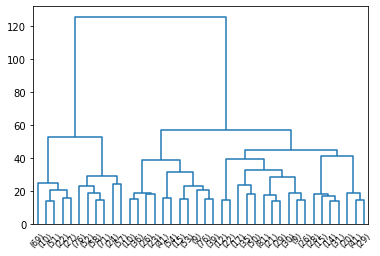

In [65]:
link = linkage(X_scaled, method='ward', metric='euclidean')
dendrogram(link, truncate_mode='lastp', p=40, color_threshold=10)
plt.show()

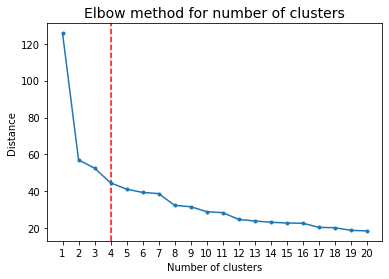

In [66]:
max_n = 20
xticks = 1 + np.arange(max_n)

fig = plt.figure()
plt.title('Elbow method for number of clusters', size=14)
plt.xlabel('Number of clusters')
plt.ylabel('Distance')
plt.xticks(xticks)
plt.axvline(x=4, color='red', linestyle='--')
plt.plot(xticks, link[-1:-max_n - 1:-1, 2], marker='.')
plt.show()

In [67]:
hierarchical = AgglomerativeClustering(n_clusters=4,
                                       affinity='euclidean', linkage='ward')

y_hierarchical = hierarchical.fit_predict(X_scaled)

df1['hierarchical_label'] = pd.Series(y_hierarchical).apply(lambda x: '0' + str(x) if x < 10 else str(x))

In [68]:
# fig = px.scatter(
#    df1,
#    x='PC1', y='PC2',
#    color='hierarchical_label',
#    hover_data=df.columns)
# fig.update_layout(title='2D PCA space (hierarchical labels)', title_x=0.5)
# fig.show()

![jupyter](./Иерархическая.PNG)

In [69]:
df1.groupby('hierarchical_label').mean()

,SalePrice,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,TotalBsmtSF,GrLivArea,BedroomAbvGr,TotRmsAbvGrd,...,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23
hierarchical_label,,,,,,,,,,,,,,,,,,,,,
00,124547.988235,8372.517647,5.084314,6.033333,1949.568627,1974.892157,804.723529,1185.458824,2.654902,5.713725,...,0.056061,0.044245,0.005372,-0.006177,-0.017084,0.014273,0.012012,-0.037900,-0.021509,-0.013737
01,194191.724852,8590.452663,6.748521,5.050296,2001.281065,2001.668639,1063.390533,1512.695266,2.665680,6.295858,...,-0.203813,-0.019274,0.054764,0.058182,-0.003505,-0.040798,-0.005932,0.051168,0.047527,0.010239
02,174202.547120,11497.439791,5.871728,5.704188,1961.167539,1974.222513,1093.892670,1609.628272,3.159686,6.840314,...,0.052070,-0.017580,-0.039532,-0.025356,0.031455,-0.003697,-0.035656,0.055649,0.026745,0.021128
03,307172.670391,11513.312849,8.111732,5.033520,2003.765363,2004.424581,1543.240223,1998.430168,2.988827,7.871508,...,0.114006,-0.052148,-0.034351,-0.038154,-0.011834,0.044260,0.053071,-0.107395,-0.085536,-0.025284


1. Кластер №1 (00)
* Средняя цена составила почти 125 тыс.дол. (самые дешевые квартиры среди кластеров), средняя площадь лота составила 8372 кв. фунтов (самая маленькая площадь среди всех четырёх кластеров), оценка общего материала дома средняя, отделка и общее состояние дома выше среднего, в среднем дома 1950 года постройки, дома в среднем реставрировали в 1975 году, площадь подвала составила в среднем 804 кв. фунтов (самое маленькое значение среди всех кластеров), жилая площадь - 1186 кв. фунт (самая маленькое значение среди всех кластеров), в среднем количество спален около трёх, а всего комнат в среднем 6, в среднем, в домах этого кластера нет камина, площадь гаража составила в среднем 352 кв. фунтов (самое маленькое значение среди всех кластеров).
2. Кластер №2 (01)
* Средняя цена составила почти 194 тыс.дол., средняя площадь лота составила 8590 кв. фунтов, оценка общего материала дома выше среднего, отделка и общее состояние дома среднее, в среднем дома 2001 года постройки, дома в среднем реставрировали в 2002 году, площадь подвала составила в среднем 1063 кв. фунтов, жилая площадь - 1513 кв. фунт, в среднем количество спален около трёх, а всего комнат в среднем 6, площадь гаража составила в среднем 510 кв. фунтов.
3. Кластер №3 (02)
* Средняя цена составила почти 174 тыс.дол., средняя плошадь лота составила 11497 кв. фунтов, оценка общего материала дома и отделка, и общее состояние дома выше среднего, в среднем дома 1961 года постройки, дома в среднем реставрировали в 1974 году, площадь подвала составила в среднем 1094 кв. фунтов, жилая площадь - 1610 кв. фунтов, в среднем количество спален больше трёх, а всего комнат в среднем 7, в среднем, в домах этого кластера есть камин, площадь гаража составила в среднем 453 кв. фунтов.
4. Кластер №4 (03)
* Средняя цена составила почти 307 тыс.дол. (самые дорогие квартиры среди кластеров), средняя плошадь лота составила 11513 кв. фунтов (самая большая площадь среди всех кластеров), оценка общего материала дома очень хорошая, отделка и общее состояние дома среднее, в среднем дома 2004 года постройки, дома в среднем реставрировали в 2005 году, площадь подвала составила в среднем 1543 кв. фунтов (самое большое значение среди всех кластеров), жилая площадь - 1609 кв. фунт (самая большое значение среди всех кластеров), в среднем количество спален - три, а всего комнат в среднем 8, в среднем, в домах этого кластера есть камин, площадь гаража составила в среднем 752 кв. фунтов (самое большое значение среди всех кластеров)

In [70]:
agg_func_stats = {'BsmtQual': ['nunique',mode,set],
                 'ExterQual': ['nunique',mode,set],
                 'KitchenQual': ['nunique',mode,set],
                 'ExterCond': ['nunique',mode,set],
                 'HeatingQC': ['nunique',mode,set],
                 'MSZoning': ['nunique',mode,set],}

In [71]:
df1.groupby('hierarchical_label').agg(agg_func_stats)

BsmtQual                                       ExterQual  \
                    nunique           mode                    set   nunique   
hierarchical_label                                                            
00                        4  ([TA], [373])  {nan, Ex, Gd, TA, Fa}         4   
01                        3  ([Gd], [311])           {TA, Ex, Gd}         3   
02                        4  ([TA], [246])       {TA, Ex, Fa, Gd}         2   
03                        2   ([Gd], [96])               {Ex, Gd}         3   

                                                    KitchenQual  \
                             mode               set     nunique   
hierarchical_label                                                
00                  ([TA], [471])  {TA, Ex, Fa, Gd}           4   
01                  ([Gd], [243])      {TA, Ex, Gd}           3   
02                  ([TA], [312])          {TA, Gd}           4   
03                  ([Gd], [135])      {TA, Ex, Gd}           3   

                                                    ExterCond                 \
                             mode               set   nunique           mode   
hierarchical_label                                                             
00                  ([TA], [389])  {TA, Ex, Fa, Gd}         5  ([TA], [389])   
01                  ([Gd], [270])      {TA, Ex, Gd}         2  ([TA], [326])   
02                  ([TA], [260])  {TA, Ex, Fa, Gd}         3  ([TA], [351])   
03                  ([Gd], [110])      {TA, Ex, Gd}         2  ([TA], [177])   

                                         HeatingQC                 \
                                     set   nunique           mode   
hierarchical_label                                                  
00                  {Po, Ex, Gd, TA, Fa}         5  ([TA], [235])   
01                              {TA, Gd}         3  ([Ex], [289])   
02                          {TA, Fa, Gd}         4  ([TA], [170])   
03                              {TA, Gd}         2  ([Ex], [173])   

                                         MSZoning                 \
                                     set  nunique           mode   
hierarchical_label                                                 
00                  {Po, Ex, Gd, TA, Fa}        4  ([RL], [332])   
01                          {TA, Ex, Gd}        4  ([RL], [261])   
02                      {TA, Ex, Fa, Gd}        3  ([RL], [357])   
03                              {Ex, Gd}        3  ([RL], [161])   

                                           
                                      set  
hierarchical_label                         
00                  {RH, RM, C (all), RL}  
01                       {RH, RM, RL, FV}  
02                           {RH, RM, RL}  
03                           {RM, RL, FV}

1. Кластер №1 (00)
* Чаще всего в домах этого кластера: Высота подвала обычная (80-89 дюймов) (только в этом кластере есть дома, где нет подвала совсем), качество материала экстерьера (единственный кластер, где есть дома с удовлетворительным качеством этого признака), качество кухни и текущее состояние материала снаружи среднее (единственный кластер, где есть плохое состояние этого признака), качество и состояние отопления среднее (единственный кластер, где есть плохое состояние этого признака), район жилой с низкой плотностью.
2. Кластер №2 (01)
* Чаще всего в домах этого кластера: Высота подвала хорошая (90-99 дюймов), качество материала экстерьера и качество кухни хорошее, текущее состояние материала снаружи среднее, качество и состояние отопления превосходное, район жилой с низкой плотностью.
3. Кластер №3 (02)
* Чаще всего в домах этого кластера: Высота подвала обычная (80-89 дюймов), качество материала экстерьера, качество кухни и текущее состояние материала снаружи среднее (единственный кластер, где есть плохое состояние этого признака), качество и состояние отопления среднее, район жилой с низкой плотностью.
4. Кластер №4 (03)
* Чаще всего в домах этого кластера: Высота подвала хорошая (90-99 дюймов), качество материала экстерьера и качество кухни хорошее, текущее состояние материала снаружи среднее, качество и состояние отопления превосходное, район жилой с низкой плотностью.

In [72]:
agg_func_stats1 = {'Condition1': ['nunique',mode,set],
                 'RoofStyle': ['nunique',mode,set],
                 'Exterior1st': ['nunique',mode,set],
                 'Exterior2nd': ['nunique',mode,set],
                 'Foundation': ['nunique',mode,set]}

In [73]:
df1.groupby('hierarchical_label').agg(agg_func_stats1)

Condition1                   \
                      nunique             mode   
hierarchical_label                               
00                          7  ([Norm], [383])   
01                          6  ([Norm], [317])   
02                          6  ([Norm], [352])   
03                          5  ([Norm], [170])   

                                                                  RoofStyle  \
                                                              set   nunique   
hierarchical_label                                                            
00                  {Norm, Feedr, RRAn, RRAe, RRNn, PosN, Artery}         6   
01                          {Norm, Feedr, RRAn, RRAe, RRNn, PosN}         2   
02                          {Norm, Feedr, RRAn, RRNe, PosN, PosA}         6   
03                                {Norm, Feedr, RRAn, RRNn, PosN}         2   

                                      \
                                mode   
hierarchical_label                     
00                  ([Gable], [447])   
01                  ([Gable], [331])   
02                  ([Gable], [250])   
03                     ([Hip], [99])   

                                                               Exterior1st  \
                                                           set     nunique   
hierarchical_label                                                           
00                  {Mansard, Gambrel, Gable, Shed, Flat, Hip}          13   
01                                                {Gable, Hip}           8   
02                  {Mansard, Gambrel, Gable, Shed, Flat, Hip}          11   
03                                                {Gable, Hip}           8   

                                        \
                                  mode   
hierarchical_label                       
00                  ([MetalSd], [121])   
01                  ([VinylSd], [270])   
02                  ([HdBoard], [107])   
03                  ([VinylSd], [142])   

                                                                       \
                                                                  set   
hierarchical_label                                                      
00                  {Wd Sdng, BrkComm, WdShing, CBlock, VinylSd, M...   
01                  {Wd Sdng, WdShing, ImStucc, MetalSd, CemntBd, ...   
02                  {Wd Sdng, Stone, WdShing, VinylSd, MetalSd, As...   
03                  {Wd Sdng, WdShing, MetalSd, CemntBd, HdBoard, ...   

                   Exterior2nd                      \
                       nunique                mode   
hierarchical_label                                   
00                          15  ([MetalSd], [115])   
01                           8  ([VinylSd], [266])   
02                          14  ([HdBoard], [100])   
03                           8  ([VinylSd], [140])   

                                                                       \
                                                                  set   
hierarchical_label                                                      
00                  {Wd Sdng, Stone, CBlock, ImStucc, VinylSd, Met...   
01                  {Wd Sdng, ImStucc, MetalSd, Wd Shng, HdBoard, ...   
02                  {Wd Sdng, Stone, ImStucc, VinylSd, MetalSd, Wd...   
03                  {ImStucc, MetalSd, Wd Shng, HdBoard, Other, Cm...   

                   Foundation                     \
                      nunique               mode   
hierarchical_label                                 
00                          5  ([CBlock], [332])   
01                          3   ([PConc], [334])   
02                          5  ([CBlock], [275])   
03                          2   ([PConc], [176])   

                                                          
                                                     set  
hierarchical_label                                        
00                  {Stone, Slab, CBlock, BrkT

0. Общее для всех кластеров:
* Чаще всего в домах Condition1 имеет значение Normal, Тип крыши - фронтон.
1. Кластер №1 (00)
* Чаще всего в домах этого кластера: наружное покрытие дома - Металлический Сайдинг, тип фундамента - Шлакоблок
2. Кластер №2 (01)
* Чаще всего в домах этого кластера: наружное покрытие дома - Виниловый Сайдинг, тип фундамента - бетон
1. Кластер №3 (02)
* Чаще всего в домах этого кластера: наружное покрытие дома - Твердая доска, тип фундамента - Шлакоблок
2. Кластер №4 (03)
* Чаще всего в домах этого кластера: наружное покрытие дома - Виниловый Сайдинг, тип фундамента - бетон

### Общий вывод по иерархической кластеризации

Мы поделили набор данных на 4 кластера:
* В первом кластере самая низкая цена на квартиры среди всех кластеров, средняя площадь лота самая маленькая среди всех четырёх кластеров, дома в основном старые, площадь подвала имеет самое маленькое значение среди всех кластеров, та же история и с жилой площадью, только в этом кластере есть дома, где нет подвала совсем, единственный кластер, где есть дома с удовлетворительным качеством материала экстерьера, единственный кластер, где есть плохое состояние материала снаружи и отопления.
* Во втором и четвёртом кластере собрались новые дома, вероятно поэтому и качество всевозможной отделки и состояния хорошие превосходные. Однако во втором кластере дома с меньшей стоимостью и площадями.
* В третьем кластере собрались старые лоты, но они больше по всевозможным площадям, хотя по качественным характеристикам не сильно лучше 1 кластера.
* В четвертом кластере (как было уже сказано ранее) дома новые, с наибольшей средней стоимостью, с самыми большими площадями, с хорошим качеством и состоянием лотов. 

### 4.2. K-means

In [74]:
inertias = []
silhouettes = []

possible_k = [i for i in range(2, 10)]
for k in possible_k:
    kmeans = KMeans(n_clusters=k, random_state=22)
    cluster_labels = kmeans.fit_predict(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X_scaled, cluster_labels))

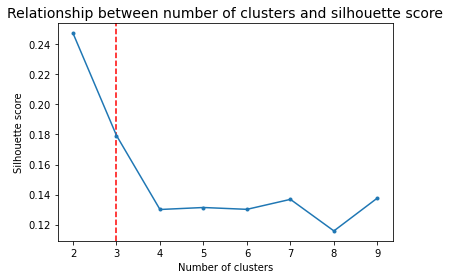

In [75]:
fig, ax = plt.subplots()
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Silhouette score')
ax.set_title('Relationship between number of clusters and silhouette score', size=14)
ax.set_xticks(possible_k)
ax.axvline(x=3, color='red', linestyle='--')
plt.plot(possible_k, silhouettes, marker='.');

Наибольшее значение силуэта у двух кластеров, однако было принято решение разделить на три кластера.

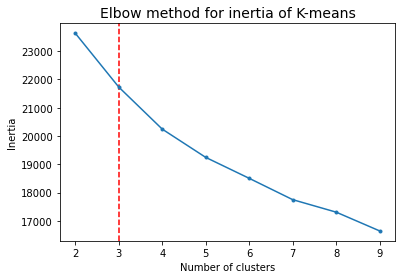

In [76]:
fig, ax = plt.subplots()
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Inertia')
ax.set_title('Elbow method for inertia of K-means', size=14)
ax.set_xticks(possible_k)
ax.axvline(x=3, color='red', linestyle='--')
plt.plot(possible_k, inertias, marker='.');

Интерпретация трёх кластеров (Кластеризация методом k-means):

In [77]:
kmeans = KMeans(n_clusters=3, random_state=22)
y_kmeans = kmeans.fit_predict(X_scaled)
df1['kmeans_label'] = pd.Series(y_kmeans).apply(lambda x: '0' + str(x) if x < 20 else str(x))

In [156]:
#fig = px.scatter(
#    df1,
#    x='PC1', y='PC2',
#    color='kmeans_label',
#    hover_data=df.columns)
#fig.update_layout(title='2D PCA space (kmeans_label)', title_x=0.5)
#fig.show()

![jupyter](./КМИНС0.PNG)

In [79]:
df1.groupby('kmeans_label').mean()

,SalePrice,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,TotalBsmtSF,GrLivArea,BedroomAbvGr,TotRmsAbvGrd,...,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23
kmeans_label,,,,,,,,,,,,,,,,,,,,,
00,167175.314149,11328.026379,5.832134,5.872902,1957.237410,1976.067146,1028.597122,1630.628297,3.235012,6.995204,...,0.000525,0.080696,0.017464,-0.019535,0.040362,-0.033805,0.016520,0.040811,0.037788,0.012511
01,115927.901532,7825.295405,4.903720,5.873085,1951.536105,1972.730853,792.179431,1053.730853,2.507659,5.312910,...,0.048906,-0.019969,-0.030321,-0.018587,-0.012452,0.019295,-0.014919,-0.049624,-0.044355,-0.016249
02,239241.871028,9956.102804,7.282243,5.104673,2000.996262,2002.142056,1257.927103,1732.607477,2.807477,6.951402,...,-0.042185,-0.045840,0.012288,0.031103,-0.020824,0.009867,-0.000133,0.010579,0.008435,0.004128


1. Кластер №1 (00)
* Средняя цена составила 167 тыс.дол., средняя плошадь лота составила 11328 кв. фунтов (самая большая площадь среди всех трёх кластеров), оценка общего материала и отделки и общее состояние дома выше среднего, в среднем дома 1957 года постройки, дома в среднем реставрировали в 1976 году, площадь подвала составила в среднем 1029 кв. фунтов, жилая площадь - 1630 кв. фунт, в среднем количество спален больше трёх, а всего комнат в среднем 7, в среднем, в кажном доме есть камин, площадь гаража составила в среднем 450 кв. фунтов.
2. Кластер №2 (01)
* Средняя цена составила почти 116 тыс.дол. (самая низкая среди трёх кластеров), средняя плошадь лота составила 7825 кв. фунтов (самая маленькая площадь), оценка общего материала и отделки среднее, а общее состояние дома выше среднего, в среднем дома 1952 года постройки (самые старые дома), дома в среднем реставрировали в 1973 году (самая ранняя реставрация), площадь подвала составила в среднем 792 кв. фунтов (самая маленькая площадь), жилая площадь - 1054 кв. фунт (самая маленькая жилая площадь), в среднем количество спален около двух, а всего комнат в среднем 5, в среднем, в кажном доме нет камина, площадь гаража составила в среднем 328 кв. фунтов (самое маленькое значение в трёх кластерах).
2. Кластер №3 (02)
* Средняя цена составила почти 239 тыс.дол. (самая высокая среди трёх кластеров (выше в 2 раза цены во втором кластере), средняя плошадь лота составила 9956 кв. фунтов, оценка общего материала и отделки выше среднего, а общее состояние дома среднее, в среднем дома 2000 года постройки (самые новые дома), дома в среднем реставрировали в 2002 году (самая поздняя реставрация), площадь подвала составила в среднем 1257 кв. фунтов (самая большая площадь), жилая площадь - 1733 кв. фунт (самая большая жилая площадь), в среднем количество спален около трёх, а всего комнат в среднем 7, в среднем, в кажном доме есть камин, площадь гаража составила в среднем 601 кв. фунтов (самое большое значение в трёх кластерах).

In [80]:
df1.groupby('kmeans_label').agg(agg_func_stats)

BsmtQual                                       ExterQual  \
              nunique           mode                    set   nunique   
kmeans_label                                                            
00                  4  ([TA], [277])  {nan, Ex, Gd, TA, Fa}         4   
01                  4  ([TA], [334])  {nan, Ex, Gd, TA, Fa}         3   
02                  3  ([Gd], [411])           {TA, Ex, Gd}         3   

                                              KitchenQual                 \
                       mode               set     nunique           mode   
kmeans_label                                                               
00            ([TA], [372])  {TA, Ex, Fa, Gd}           4  ([TA], [297])   
01            ([TA], [435])      {TA, Fa, Gd}           4  ([TA], [375])   
02            ([Gd], [418])      {TA, Ex, Gd}           3  ([Gd], [414])   

                               ExterCond                                       \
                           set   nunique           mode                   set   
kmeans_label                                                                    
00            {TA, Ex, Fa, Gd}         4  ([TA], [350])      {TA, Ex, Fa, Gd}   
01            {TA, Ex, Fa, Gd}         5  ([TA], [378])  {Po, Ex, Gd, TA, Fa}   
02                {TA, Ex, Gd}         2  ([TA], [515])              {TA, Gd}   

             HeatingQC                                      MSZoning  \
               nunique           mode                   set  nunique   
kmeans_label                                                           
00                   4  ([TA], [180])      {TA, Ex, Fa, Gd}        5   
01                   5  ([TA], [222])  {Po, Ex, Gd, TA, Fa}        4   
02                   3  ([Ex], [485])          {TA, Ex, Gd}        4   

                                                        
                       mode                        set  
kmeans_label                                            
00            ([RL], [372])  {RL, C (all), RM, FV, RH}  
01            ([RL], [292])      {RH, RM, C (all), RL}  
02            ([RL], [447])           {RH, RM, RL, FV}

1. Кластер №1 (00)
* Чаще всего в домах этого кластера: Высота подвала обычная (80-89 дюймов), качество материала экстерьера, качество кухни и текущее состояние материала снаружи среднее, качество и состояние отопления среднее, район жилой с низкой плотностью.
2. Кластер №2 (01)
* Чаще всего в домах этого кластера: Высота подвала обычная (80-89 дюймов), качество материала экстерьера, качество кухни и текущее состояние материала снаружи среднее (единственный кластер, где есть дома с плохим качеством), качество и состояние отопления среднее (единственный кластер, где есть дома с плохим качеством), район жилой с низкой плотностью.
3. Кластер №3 (02)
* Чаще всего в домах этого кластера: Высота подвала хорошая (90-99 дюймов), качество материала экстерьера и качество кухни хорошее, текущее состояние материала снаружи среднее, качество и состояние отопления превосходное, район жилой с низкой плотностью.

In [81]:
df1.groupby('kmeans_label').agg(agg_func_stats1)

Condition1                   \
                nunique             mode   
kmeans_label                               
00                    7  ([Norm], [336])   
01                    7  ([Norm], [384])   
02                    8  ([Norm], [502])   

                                                                RoofStyle  \
                                                            set   nunique   
kmeans_label                                                                
00                {Norm, Feedr, RRAn, PosA, RRAe, PosN, Artery}         6   
01                {Norm, Feedr, RRAn, RRAe, RRNn, PosN, Artery}         5   
02            {Norm, Feedr, RRAn, RRNe, RRAe, RRNn, PosN, PosA}         4   

                                                                            \
                          mode                                         set   
kmeans_label                                                                 
00            ([Gable], [312])  {Mansard, Gambrel, Gable, Shed, Flat, Hip}   
01            ([Gable], [376])        {Mansard, Gambrel, Gable, Flat, Hip}   
02            ([Gable], [420])                    {Flat, Gable, Shed, Hip}   

             Exterior1st                      \
                 nunique                mode   
kmeans_label                                   
00                    10  ([HdBoard], [100])   
01                    13  ([MetalSd], [112])   
02                    11  ([VinylSd], [402])   

                                                                Exterior2nd  \
                                                            set     nunique   
kmeans_label                                                                  
00            {Wd Sdng, WdShing, VinylSd, MetalSd, AsbShng, ...          14   
01            {Wd Sdng, BrkComm, WdShing, CBlock, VinylSd, M...          15   
02            {Wd Sdng, Stone, WdShing, ImStucc, MetalSd, Ce...          11   

                                  \
                            mode   
kmeans_label                       
00             ([Wd Sdng], [96])   
01            ([MetalSd], [109])   
02            ([VinylSd], [396])   

                                                                Foundation  \
                                                            set    nunique   
kmeans_label                                                                 
00            {Wd Sdng, Stone, ImStucc, VinylSd, MetalSd, Wd...          6   
01            {Wd Sdng, Stone, CBlock, ImStucc, MetalSd, Wd ...          6   
02            {Wd Sdng, Stone, ImStucc, MetalSd, Wd Shng, Hd...          3   

                                                                             
                           mode                                         set  
kmeans_label                                                                 
00            ([CBlock], [299])  {Stone, Slab, CBlock, Wood, BrkTil, PConc}  
01            ([CBlock], [298])  {Stone, Slab, CBlock, Wood, BrkTil, PConc}  
02             ([PConc], [518])                      {PConc, Stone, CBlock}

0. Общее для всех кластеров:
* Чаще всего в домах Condition1 имеет значение Normal, Тип крыши - фронтон.
1. Кластер №1 (00)
* Чаще всего в домах этого кластера: наружное покрытие дома - жесткая доска и деревянный Сайдинг, тип фундамента - Шлакоблок
2. Кластер №1 (01)
* Чаще всего в домах этого кластера: наружное покрытие дома - Металлический Сайдинг, тип фундамента - Шлакоблок
3. Кластер №1 (02)
* Чаще всего в домах этого кластера: наружное покрытие дома - Виниловый Сайдинг, тип фундамента - бетон

### Общий вывод по кластеризации k-means

Было принято решение делить данные на 3 кластера.
* Третий кластер содержит в себе дома, которые в среднем имеют наибольшую стоимость, оценка общего материала и отделки выше среднего, дома новые и отреставрированы в среднем в 21 веке, в среднем тут большие подвалы (по площади и по высоте), наибольшая средняя жилая площадь и площадь гаража, качество материала экстерьера и качество кухни хорошее, текущее состояние материала снаружи среднее, качество и состояние отопления превосходное.
* Первый кластер содержит в себе дома среднего сегмента, они не самые догорие, качество у них среднее, все возможные площади тоже, дома в среднем "старее" домов третьего кластера, но новее домов второго кластера.
* Второй кластер содержит в себе самые дешевые лоты, с самыми маленькими площадями, с самыми старыми домами и  хоть качество материала экстерьера, качество кухни и текущее состояние материала снаружи среднее это единственный кластер, где есть дома с плохим качеством, качество и состояние отопления среднее, однако это единственный кластер, где есть дома с плохим качеством

### 4.3. DBSCAN

Опытным путём было получено, что 3 соседа - оптимальное количество соседей, тогда найдём оптимальное значение эпсилон:

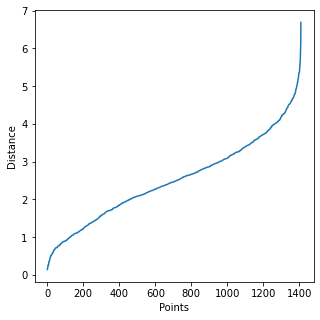

In [82]:
nearest_neighbors1 = NearestNeighbors(n_neighbors=4)
neighbors1 = nearest_neighbors1.fit(X_scaled)
distances, indices = neighbors1.kneighbors(X_scaled)

distances = np.sort(distances[:, 3], axis=0)
i = np.arange(len(distances))
knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')

fig = plt.figure(figsize=(5, 5))
plt.plot(distances)
plt.xlabel("Points")
plt.ylabel("Distance");

plt.savefig("Distance_curve.png", dpi=300)

3.8213814547812257


<Figure size 360x360 with 0 Axes>

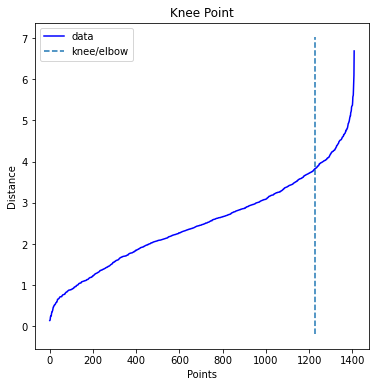

In [83]:
fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")
plt.savefig("knee.png", dpi=300)
print(distances[knee.knee])

In [84]:
dbscan = DBSCAN(eps=distances[knee.knee], min_samples=3)
y_dbscan = dbscan.fit_predict(X_scaled)

df1['dbscan_label'] = pd.Series(y_dbscan).apply(lambda x: '0' + str(x) if 0 <= x < 10 else str(x))

In [85]:
# fig = px.scatter(
#    df1,
#    x='PC1', y='PC2',
#    color='dbscan_label',
#    hover_data=df.columns)
# fig.update_layout(title='2D PCA space (dbscan_label)', title_x=0.5)
# fig.show()

![jupyter](./ДБСКАН.PNG)

Откровенно говоря, DBSCAN не справился со своей задачей так хорошо, как ожидалось. Разделение на кластеры плохое. Интерпретировать это желания нет, однако выведем средние значения по кластерам. Просто. Чтобы было:

In [86]:
df1.groupby('dbscan_label').mean()

,SalePrice,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,TotalBsmtSF,GrLivArea,BedroomAbvGr,TotRmsAbvGrd,...,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23
dbscan_label,,,,,,,,,,,,,,,,,,,,,
-1,156285.467290,12028.663551,5.429907,6.112150,1941.448598,1977.504673,799.607477,1624.514019,2.897196,6.943925,...,-0.175865,-0.050787,0.161574,0.167713,0.098448,0.124393,0.110508,0.013839,0.038299,0.046544
00,181226.265466,9505.711825,6.167580,5.543461,1975.028974,1986.007831,1075.870791,1475.667189,2.833986,6.396241,...,0.009619,0.006164,-0.020435,-0.021756,0.000709,-0.004525,-0.004783,-0.000475,-0.002156,-0.003241
01,100261.684211,8482.947368,4.210526,4.947368,1954.842105,1960.473684,0.000000,1221.105263,2.736842,6.315789,...,0.285080,-0.045580,0.479387,0.547342,-0.595494,-0.286983,-0.298721,-0.038028,-0.049263,-0.044382
02,105350.000000,6570.833333,5.333333,6.166667,1927.333333,1955.000000,749.500000,1170.166667,2.666667,5.500000,...,0.186170,-0.261875,-0.050192,-0.093728,-0.020829,-0.346442,-0.006745,-0.025212,-0.068112,0.000355


## 5. Уменьшение размерности

### 5.1. Метод главных компонент

Выше метод главных компонент был применен, чтобы можно было визуализировать кластеры в рамках первых двух компонент. Теперь уменьшим размерность с помощью МГК.

In [87]:
X_scaled.shape == PC.shape

True

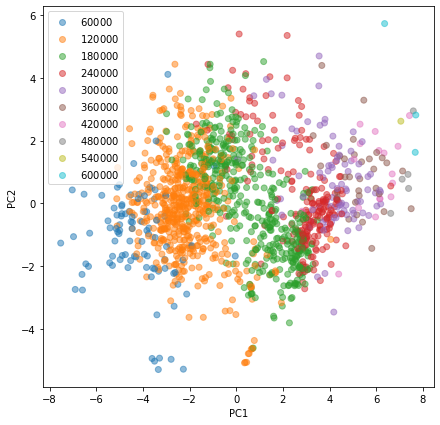

In [88]:
fig, ax = plt.subplots(figsize=[7, 7])
plot = ax.scatter(PC[:, 0], PC[:, 1], c=df['SalePrice'], alpha=0.5, cmap='tab10')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.legend(*plot.legend_elements())
plt.show()

Отбираем компоненты с дисперсией, большей 1:

In [89]:
n1 = (pca.explained_variance_ > 1).sum()
n1

5

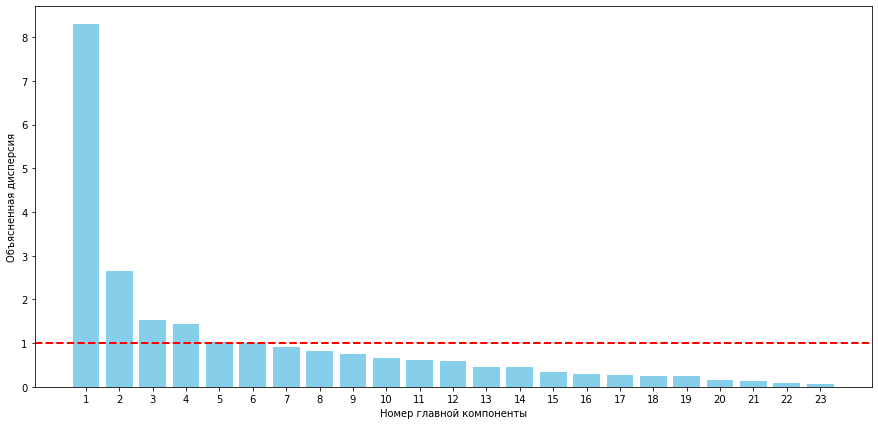

In [90]:
plt.figure(figsize=(15,7))
plt.xticks(range(1, len(pca.explained_variance_)+1))
plt.bar(range(1, len(pca.explained_variance_)+1), pca.explained_variance_, color='skyblue')
plt.axhline(y=1, color='r', linestyle='--', linewidth=2)
plt.xlabel('Номер главной компоненты')
plt.ylabel('Объясненная дисперсия');

Компоненты, объясняющие 90% и более общей дисперсии:

In [91]:
cum_var = pca.explained_variance_ratio_.cumsum()
n2 = (cum_var <= 0.9).sum() + 1
epx_var_n2 = sum(pca.explained_variance_ratio_[:n2])*100
print(f'{n2} компонент объясняют {round(epx_var_n2, 2)}% общей дисперсии')

14 компонент объясняют 91.92% общей дисперсии


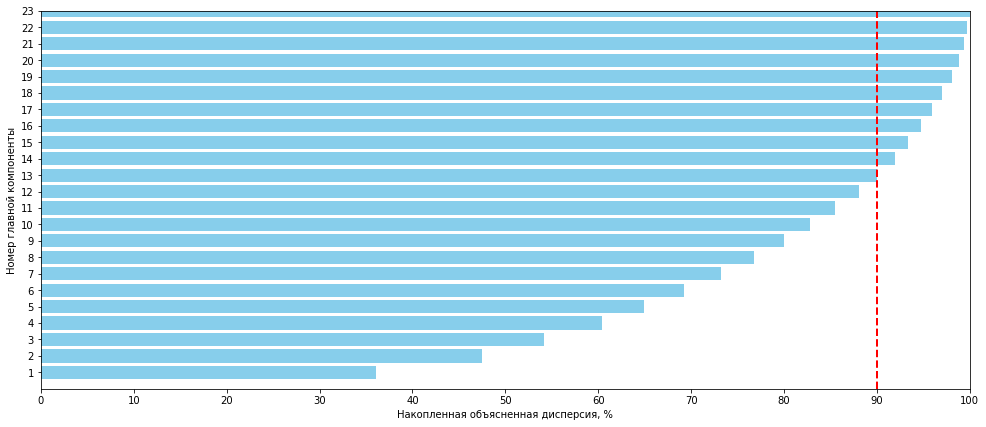

In [92]:
fig = plt.figure(figsize=(15,7))
ax = fig.add_axes([0.1, 0.18, 0.86, 0.75])
ax.axis([0, 100, 0, 11])
plt.yticks(range(1, len(cum_var)+1))
plt.xticks(range(0, 101, 10))
plt.barh(range(1, len(cum_var)+1), cum_var*100, color='skyblue')
plt.vlines(90, 0, len(cum_var)+1, color='r', linestyle='--', linewidth=2)
plt.ylabel('Номер главной компоненты')
plt.xlabel('Накопленная объясненная дисперсия, %');

Составим новый датафрейм из 14 первых компонент, объясняющих более 90% (а именно 91.92%) общей дисперсии, и проведем кластеризацию снова.

In [93]:
df_pca = pd.DataFrame({'PCA1': PC[:, 0],
                    'PCA2': PC[:, 1],
                    'PCA3': PC[:, 2],
                    'PCA4': PC[:, 3],
                    'PCA5': PC[:, 4],
                    'PCA6': PC[:, 5],
                    'PCA7': PC[:, 6],
                    'PCA8': PC[:, 7],
                    'PCA9': PC[:, 8],
                    'PCA10': PC[:, 9],
                    'PCA11': PC[:, 10],
                    'PCA12': PC[:, 11],
                    'PCA13': PC[:, 12],
                    'PCA14': PC[:, 13]})
df_pca

,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10,PCA11,PCA12,PCA13,PCA14
0,2.763557,-1.007210,-0.261364,1.628244,-0.278784,-0.384989,-0.017009,0.699296,-0.321069,0.083976,0.237024,0.065901,0.219713,-0.085738
1,-0.989198,0.812912,1.427667,-0.508672,0.511750,0.869999,2.226657,-0.048041,-0.332628,-0.027958,-1.840126,-0.604123,-1.362402,0.336696
2,2.977693,-0.754823,-0.252626,0.686539,-0.353407,-0.015170,0.439405,-0.227969,0.690666,0.127714,0.181233,0.265726,0.033371,-0.384150
3,-1.177014,1.898058,-0.085323,-0.225123,0.449157,-1.064103,0.757242,-0.033530,0.482030,0.712913,0.936979,0.012756,-0.061520,0.766583
4,4.269322,1.335197,-0.399798,1.512397,-0.305838,0.120647,0.128847,-0.110411,0.014057,0.620113,0.428704,0.204140,-0.344814,-0.232200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1404,1.435707,-0.767895,-0.708365,1.293042,-0.528254,0.137274,-0.058003,-0.626001,0.578877,-0.920120,-0.516967,0.220039,-1.249337,-0.501659
1405,0.461092,2.235679,-0.304130,-0.889807,-0.165274,-0.024563,0.257432,-2.076662,0.619611,-0.077511,-0.669785,-0.930590,-0.457809,-0.290202
1406,2.718230,1.860760,4.558283,1.947229,-0.120447,0.359000,-0.572070,-0.855472,2.041379,-1.043565,-0.328368,-0.790539,1.296969,1.707660
1407,-1.806157,-0.569007,0.485070,-2.012886,-0.014998,-0.044638,-0.735368,1.824820,0.165522,-0.018249,-0.734650,0.099113,0.743247,-0.033244


### 5.1.1. K-means

In [94]:
inertias = []
silhouettes = []

possible_k = [i for i in range(2, 10)]
for k in possible_k:
    kmeans = KMeans(n_clusters=k, random_state=22)
    cluster_labels = kmeans.fit_predict(df_pca)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(df_pca, cluster_labels))

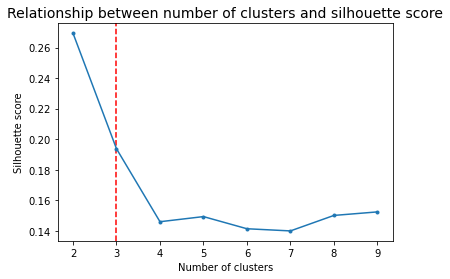

In [95]:
fig, ax = plt.subplots()
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Silhouette score')
ax.set_title('Relationship between number of clusters and silhouette score', size=14)
ax.set_xticks(possible_k)
ax.axvline(x=3, color='red', linestyle='--')
plt.plot(possible_k, silhouettes, marker='.');

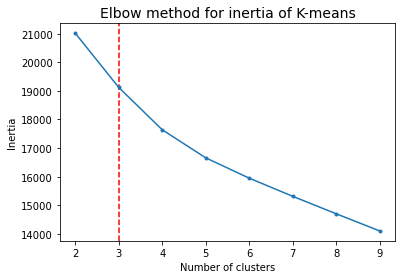

In [96]:
fig, ax = plt.subplots()
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Inertia')
ax.set_title('Elbow method for inertia of K-means', size=14)
ax.set_xticks(possible_k)
ax.axvline(x=3, color='red', linestyle='--')
plt.plot(possible_k, inertias, marker='.');

In [97]:
df2 = df.copy()

for i in range(n):
    df2['PC' + str(i + 1)] = PC[:, i]

In [98]:
kmeans = KMeans(n_clusters=3, random_state=22)
y_kmeans = kmeans.fit_predict(df_pca)
df2['kmeans_label'] = pd.Series(y_kmeans).apply(lambda x: '0' + str(x) if x < 20 else str(x))
df2.sort_values('kmeans_label', inplace=True)

In [99]:
#fig = px.scatter(
#    df2,
#    x='PC1', y='PC2',
#    color='kmeans_label',
#    hover_data=df.columns)
#fig.update_layout(title='2D PCA space (kmeans_label) после уменьшения размерности', title_x=0.5)
#fig.show()

![jupyter](./KMEANS.PNG)

Объединение на кластеры СОВПАЛО С ПРЕДЫДУЩЕЙ КЛАСТЕРИЗАЦИЕЙ K-means БЕЗ УМЕНЬШЕНИЯ РАЗМЕРНОСТИ, ТОЛЬКО КЛАСТЕРЫ ПОМЕНЯЛИСЬ МЕСТАМИ.

In [100]:
df2.groupby('kmeans_label').mean()

,SalePrice,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,TotalBsmtSF,GrLivArea,BedroomAbvGr,TotRmsAbvGrd,...,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23
kmeans_label,,,,,,,,,,,,,,,,,,,,,
00,239298.125704,9941.461538,7.281426,5.103189,2001.075047,2002.225141,1255.816135,1732.243902,2.804878,6.953096,...,-0.043843,-0.045000,0.012704,0.028410,-0.016833,0.012737,-0.000862,0.010796,0.007518,0.004067
01,166912.834499,11308.724942,5.829837,5.885781,1957.391608,1975.871795,1033.130536,1619.902098,3.228438,6.962704,...,0.014523,0.068513,0.008908,-0.021631,0.030762,-0.037439,0.010599,0.037947,0.037905,0.012195
02,115288.704698,7776.778523,4.892617,5.859060,1951.362416,1972.861298,786.082774,1052.008949,2.498881,5.304251,...,0.038340,-0.012097,-0.023698,-0.013116,-0.009451,0.020744,-0.009144,-0.049292,-0.045343,-0.016554


In [101]:
df2.groupby('kmeans_label').agg(agg_func_stats)

BsmtQual                                       ExterQual  \
              nunique           mode                    set   nunique   
kmeans_label                                                            
00                  3  ([Gd], [410])           {TA, Ex, Gd}         3   
01                  4  ([TA], [286])  {nan, Ex, Gd, TA, Fa}         4   
02                  4  ([TA], [326])  {nan, Ex, Gd, TA, Fa}         3   

                                              KitchenQual                 \
                       mode               set     nunique           mode   
kmeans_label                                                               
00            ([Gd], [417])      {TA, Ex, Gd}           3  ([Gd], [413])   
01            ([TA], [382])  {TA, Ex, Fa, Gd}           4  ([TA], [307])   
02            ([TA], [426])      {Fa, Gd, TA}           4  ([TA], [366])   

                               ExterCond                                       \
                           set   nunique           mode                   set   
kmeans_label                                                                    
00                {TA, Ex, Gd}         2  ([TA], [514])              {TA, Gd}   
01            {TA, Ex, Fa, Gd}         4  ([TA], [360])      {TA, Ex, Fa, Gd}   
02            {TA, Ex, Fa, Gd}         5  ([TA], [369])  {Po, Ex, Gd, TA, Fa}   

             HeatingQC                                      MSZoning  \
               nunique           mode                   set  nunique   
kmeans_label                                                           
00                   3  ([Ex], [483])          {TA, Ex, Gd}        4   
01                   4  ([TA], [182])      {TA, Ex, Fa, Gd}        5   
02                   5  ([TA], [220])  {Po, Ex, Gd, TA, Fa}        4   

                                                        
                       mode                        set  
kmeans_label                                            
00            ([RL], [445])           {RH, RM, RL, FV}  
01            ([RL], [383])  {RL, C (all), RM, FV, RH}  
02            ([RL], [283])      {RL, RM, C (all), RH}

Так как итоги кластеризации практически полностью совпали (совсем немного изменились значения средних), то принято решение не дублировать интерпретацию.

### 5.1.2. Иерархическая кластеризация

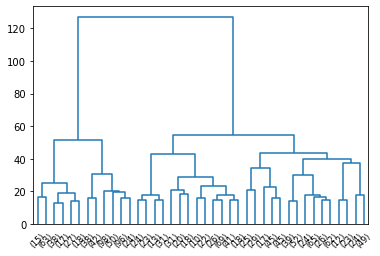

In [102]:
link = linkage(df_pca, method='ward', metric='euclidean')
dendrogram(link, truncate_mode='lastp', p=40, color_threshold=10)
plt.show()

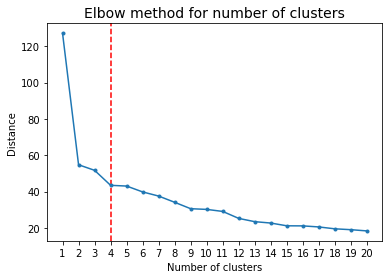

In [103]:
max_n = 20
xticks = 1 + np.arange(max_n)

fig = plt.figure()
plt.title('Elbow method for number of clusters', size=14)
plt.xlabel('Number of clusters')
plt.ylabel('Distance')
plt.xticks(xticks)
plt.axvline(x=4, color='red', linestyle='--')
plt.plot(xticks, link[-1:-max_n - 1:-1, 2], marker='.')
plt.show()

In [104]:
hierarchical = AgglomerativeClustering(n_clusters=4,
                                       affinity='euclidean', linkage='ward')

y_hierarchical = hierarchical.fit_predict(df_pca)

df2['hierarchical_label'] = pd.Series(y_hierarchical).apply(lambda x: '0' + str(x) if x < 10 else str(x))

In [105]:
#fig = px.scatter(
#    df1,
#    x='PC1', y='PC2',
#    color='hierarchical_label',
#    hover_data=df.columns)
# fig.update_layout(title='2D PCA space (hierarchical labels) после уменшения размерности', title_x=0.5)
#fig.show()

![jupyter](./Иерархическая1.PNG)

Итоги кластеризации такие же. Кластеры даже не поменялись местами. Немного отличаются значения средних, но не критично. Поэтому соображениям не будем интерпретировать повторно

In [106]:
df2.groupby('hierarchical_label').mean()

,SalePrice,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,TotalBsmtSF,GrLivArea,BedroomAbvGr,TotRmsAbvGrd,...,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23
hierarchical_label,,,,,,,,,,,,,,,,,,,,,
00,124112.383613,8253.649907,5.094972,5.631285,1954.819367,1971.472998,845.324022,1160.158287,2.610801,5.581006,...,0.016882,0.006586,-0.055717,-0.014055,-0.024345,-0.004902,-0.030722,-0.013411,-0.022774,-0.018194
01,199823.376437,8833.810345,6.827586,5.071839,2000.385057,2001.091954,1082.850575,1558.701149,2.761494,6.479885,...,-0.140930,-0.029003,0.059886,0.056377,0.007137,-0.028851,0.013177,0.042967,0.046983,0.005339
02,169922.462428,11550.991329,5.809249,6.303468,1954.242775,1979.838150,1027.164740,1601.913295,3.153179,6.881503,...,0.069433,0.034125,0.055391,-0.019832,0.028410,0.014429,0.023042,0.033809,0.029714,0.035946
03,312952.252809,11929.455056,8.129213,5.022472,2002.882022,2003.477528,1560.516854,2071.780899,3.050562,8.039326,...,0.089632,-0.029499,-0.056662,-0.029268,0.004269,0.043145,0.022131,-0.109264,-0.080908,-0.025420


### 5.1.3. DBSCAN

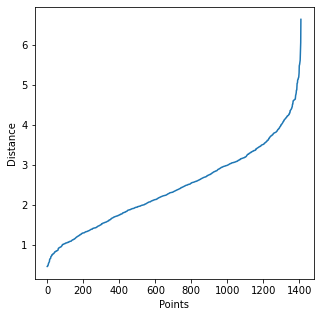

In [107]:
nearest_neighbors1 = NearestNeighbors(n_neighbors=8)
neighbors1 = nearest_neighbors1.fit(df_pca)
distances, indices = neighbors1.kneighbors(df_pca)

distances = np.sort(distances[:, 7], axis=0)
i = np.arange(len(distances))
knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')

fig = plt.figure(figsize=(5, 5))
plt.plot(distances)
plt.xlabel("Points")
plt.ylabel("Distance");

plt.savefig("Distance_curve.png", dpi=300)

3.618166586297159


<Figure size 360x360 with 0 Axes>

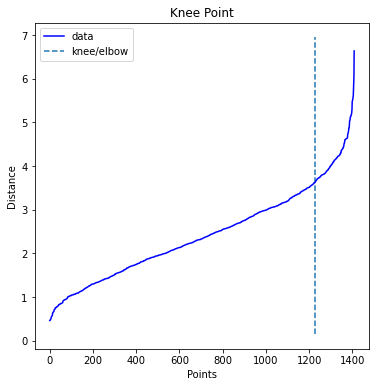

In [108]:
fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")
plt.savefig("knee.png", dpi=300)
print(distances[knee.knee])

In [109]:
dbscan = DBSCAN(eps=distances[knee.knee], min_samples=7)
y_dbscan = dbscan.fit_predict(df_pca)

df2['dbscan_label'] = pd.Series(y_dbscan).apply(lambda x: '0' + str(x) if 0 <= x < 10 else str(x))

DBSCAN в очередной раз сработал плохо.

In [110]:
# fig = px.scatter(
#    df2,
#    x='PC1', y='PC2',
#    color='dbscan_label',
#    hover_data=df.columns)
# fig.update_layout(title='2D PCA space (dbscan_label) после уменьшения размерности МГК', title_x=0.5)
# fig.show()

![jupyter](./ДБСКАН1.PNG)

In [111]:
df2.groupby('dbscan_label').mean()

,SalePrice,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,TotalBsmtSF,GrLivArea,BedroomAbvGr,TotRmsAbvGrd,...,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23
dbscan_label,,,,,,,,,,,,,,,,,,,,,
-1,153566.328571,12881.485714,5.414286,6.171429,1940.900000,1977.428571,787.314286,1606.071429,3.014286,6.928571,...,-0.411918,0.050103,0.087113,0.052437,-0.014650,-0.014371,0.052478,-0.017229,0.040059,0.006914
00,180628.952055,9513.743531,6.151446,5.561644,1973.960426,1985.698630,1072.168950,1480.686454,2.828767,6.412481,...,0.016706,-0.003023,-0.011020,-0.011125,0.013734,0.007854,0.002869,0.000976,-0.000798,-0.000247
01,103578.880000,8947.960000,4.280000,4.960000,1956.240000,1963.040000,0.000000,1217.000000,2.760000,6.120000,...,0.275285,0.018579,0.335306,0.437899,-0.680845,-0.372593,-0.297727,-0.003082,-0.070201,-0.006387


### 5.2. t-SNE

In [112]:
def low_dim_scatter(data):
    fig, ax = plt.subplots(figsize=[7, 7])
    plot = ax.scatter(data[:, 0], data[:, 1], c=y, alpha=0.5, cmap='tab10')
    ax.set_xlabel('Y1')
    ax.set_ylabel('Y2')
    ax.legend(*plot.legend_elements())
    plt.show()

In [113]:
y = df.iloc[:, 0].values

После домашней работы можно прям порадоваться тому, как быстро летает t-SNE

In [114]:
%%time
X_tsne2 = TSNE(n_components=2, perplexity=100).fit_transform(X_scaled)

Wall time: 18.5 s


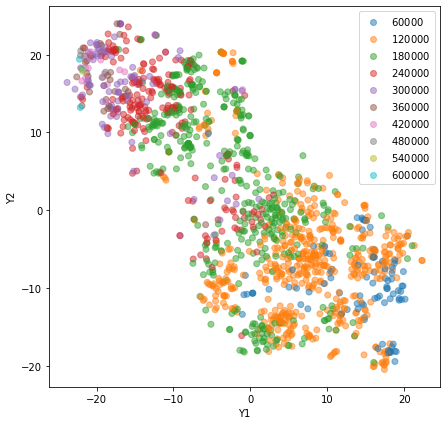

In [115]:
low_dim_scatter(X_tsne2)

In [116]:
tsne_df = pd.DataFrame(X_tsne2, columns=["tsne_dim1", "tsne_dim2"])
tsne_df

,tsne_dim1,tsne_dim2
0,-10.646941,12.479045
1,10.220346,-15.300571
2,-13.217403,12.838833
3,2.062892,-2.225669
4,-17.744579,12.858466
...,...,...
1404,-8.035492,8.559482
1405,1.880148,0.926610
1406,-9.189368,-3.259853
1407,5.603998,-14.868092


### 5.2.1. K-means

In [117]:
inertias = []
silhouettes = []

possible_k = [i for i in range(2, 15)]
for k in possible_k:
    kmeans = KMeans(n_clusters=k, random_state=22)
    cluster_labels = kmeans.fit_predict(tsne_df)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(tsne_df, cluster_labels))

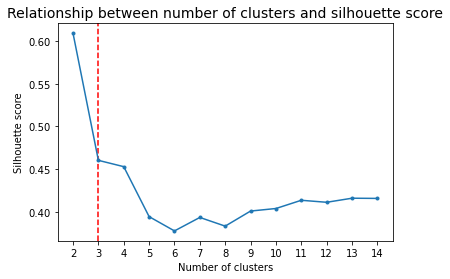

In [118]:
fig, ax = plt.subplots()
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Silhouette score')
ax.set_title('Relationship between number of clusters and silhouette score', size=14)
ax.set_xticks(possible_k)
ax.axvline(x=3, color='red', linestyle='--')
plt.plot(possible_k, silhouettes, marker='.');

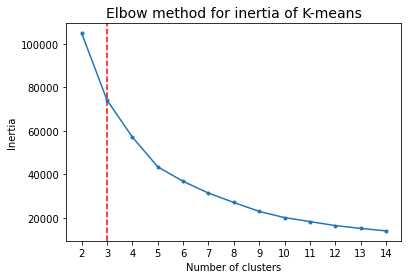

In [119]:
fig, ax = plt.subplots()
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Inertia')
ax.set_title('Elbow method for inertia of K-means', size=14)
ax.set_xticks(possible_k)
ax.axvline(x=3, color='red', linestyle='--')
plt.plot(possible_k, inertias, marker='.');

In [120]:
df_t = df.copy()
df_t['tsne_dim1'] = tsne_df['tsne_dim1']
df_t['tsne_dim2'] = tsne_df['tsne_dim2']

In [121]:
kmeans = KMeans(n_clusters=3, random_state=22)
y_kmeans = kmeans.fit_predict(tsne_df)
df_t['kmeans_label'] = pd.Series(y_kmeans)
df_t.sort_values('kmeans_label', inplace=True)

In [157]:
#fig = px.scatter(
#    df_t,
#    x='tsne_dim1', y='tsne_dim2',
#    color='kmeans_label',
#    hover_data=df.columns)
#fig.update_layout(title='2D tSNE space (kmeans_label)', title_x=0.5)
#fig.show()

![jupyter](./КМИНС_ТСНЕ.PNG)

In [123]:
df_t.groupby('kmeans_label').mean()

,SalePrice,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,TotalBsmtSF,GrLivArea,BedroomAbvGr,TotRmsAbvGrd,Fireplaces,GarageArea,tsne_dim1,tsne_dim2
kmeans_label,,,,,,,,,,,,,,
0,115032.400593,7939.810089,4.985163,5.602374,1943.275964,1965.887240,743.439169,1225.097923,2.718101,5.863501,0.335312,321.014837,13.986924,-9.026357
1,235459.673358,9801.981752,7.228102,5.076642,2001.268248,2002.065693,1236.916058,1708.000000,2.801095,6.908759,0.691606,593.224453,-11.691561,14.577022
2,158182.706107,10647.442748,5.587786,6.095420,1959.874046,1979.137405,1022.085878,1411.507634,2.950382,6.301527,0.656489,432.417939,1.894769,-5.919598


Опять же кластеры совпадают по формированию, но в этом случае (на наш взгляд) более четко видно разница между ними. В том числе кластер с самыми дешевыми лотами и самой маленькой всевозможной площадью теперь содержит в себе более "старые" дома. В то время как отличие кластера с дорогими домами сияет своим "превосходством" ещё сильнее. 

In [124]:
df_t.groupby('kmeans_label').agg(agg_func_stats)

BsmtQual                                       ExterQual  \
              nunique           mode                    set   nunique   
kmeans_label                                                            
0                   4  ([TA], [246])  {nan, Ex, Gd, TA, Fa}         3   
1                   3  ([Gd], [426])           {TA, Ex, Gd}         3   
2                   4  ([TA], [367])  {nan, Ex, Gd, TA, Fa}         4   

                                              KitchenQual                 \
                       mode               set     nunique           mode   
kmeans_label                                                               
0             ([TA], [323])      {TA, Fa, Gd}           4  ([TA], [280])   
1             ([Gd], [409])      {TA, Ex, Gd}           3  ([Gd], [409])   
2             ([TA], [461])  {TA, Ex, Fa, Gd}           4  ([TA], [373])   

                               ExterCond                                   \
                           set   nunique           mode               set   
kmeans_label                                                                
0             {TA, Ex, Fa, Gd}         4  ([TA], [294])  {Fa, Po, Gd, TA}   
1                 {TA, Ex, Gd}         2  ([TA], [530])          {TA, Gd}   
2             {TA, Ex, Fa, Gd}         4  ([TA], [419])  {TA, Ex, Fa, Gd}   

             HeatingQC                                      MSZoning  \
               nunique           mode                   set  nunique   
kmeans_label                                                           
0                    5  ([TA], [174])  {Po, Ex, Gd, TA, Fa}        4   
1                    3  ([Ex], [490])          {TA, Ex, Gd}        4   
2                    4  ([TA], [229])      {TA, Ex, Fa, Gd}        2   

                                                    
                       mode                    set  
kmeans_label                                        
0             ([RL], [159])  {RH, RM, C (all), RL}  
1             ([RL], [452])       {RH, RM, RL, FV}  
2             ([RL], [500])               {RM, RL}

Но в целом интерпретация кластеров не сильно изменилась.

### 5.2.2. Иерархическая кластеризация

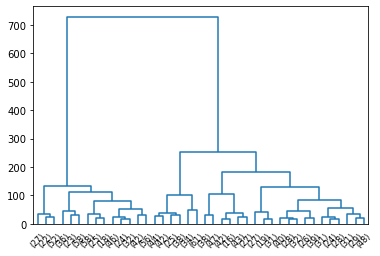

In [125]:
link = linkage(tsne_df, method='ward', metric='euclidean')
dendrogram(link, truncate_mode='lastp', p=40, color_threshold=10)
plt.show()

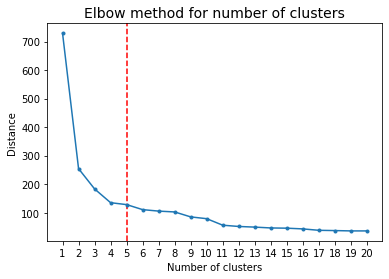

In [126]:
max_n = 20
xticks = 1 + np.arange(max_n)

fig = plt.figure()
plt.title('Elbow method for number of clusters', size=14)
plt.xlabel('Number of clusters')
plt.ylabel('Distance')
plt.xticks(xticks)
plt.axvline(x=5, color='red', linestyle='--')
plt.plot(xticks, link[-1:-max_n -
                      1:-1, 2], marker='.')
plt.show()

In [127]:
hierarchical = AgglomerativeClustering(n_clusters=5,
                                       affinity='euclidean', linkage='ward')

y_hierarchical = hierarchical.fit_predict(tsne_df)

df_t['hierarchical_label'] = pd.Series(y_hierarchical)

In [159]:
#fig = px.scatter(
#    df_t,
#    x='tsne_dim1', y='tsne_dim2',
#    color='hierarchical_label',
#    hover_data=df.columns)
#fig.update_layout(title='2D tSNE space (hierarchical label)', title_x=0.5)
#fig.show()

![jupyter](./Иерархическая_ТСНЕ.PNG)

In [129]:
df_t.groupby('hierarchical_label').mean()

,SalePrice,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,TotalBsmtSF,GrLivArea,BedroomAbvGr,TotRmsAbvGrd,Fireplaces,GarageArea,tsne_dim1,tsne_dim2,kmeans_label
hierarchical_label,,,,,,,,,,,,,,,
0,157564.734411,10483.445727,5.581986,5.806005,1961.939954,1977.214781,991.956120,1409.046189,2.958430,6.297921,0.625866,413.743649,4.002448,-2.170047,1.591224
1,217770.456938,9376.150718,7.028708,5.074163,2001.698565,2002.320574,1151.744019,1636.854067,2.779904,6.681818,0.588517,573.007177,-10.520432,13.796002,1.000000
2,111705.401639,7540.151639,4.963115,5.635246,1939.106557,1966.536885,682.385246,1272.569672,2.729508,6.036885,0.344262,332.020492,15.702642,-9.583351,0.000000
3,149101.403756,9999.887324,5.507042,6.309859,1957.643192,1978.685446,1019.333333,1304.882629,2.802817,5.957746,0.572770,414.018779,0.370278,-12.390092,1.821596
4,320962.970297,11862.633663,8.217822,5.049505,2002.009901,2003.019802,1676.990099,2036.663366,2.881188,7.940594,1.118812,712.762376,-19.270857,19.750345,1.000000


In [130]:
df_t.groupby('hierarchical_label').agg(agg_func_stats)

BsmtQual                                       ExterQual  \
                    nunique           mode                    set   nunique   
hierarchical_label                                                            
0                         4  ([TA], [271])  {nan, Ex, Gd, TA, Fa}         3   
1                         3  ([Gd], [355])           {TA, Ex, Gd}         3   
2                         3  ([TA], [169])      {nan, Fa, Gd, TA}         3   
3                         3  ([TA], [174])           {TA, Fa, Gd}         4   
4                         3   ([Ex], [55])           {TA, Ex, Gd}         3   

                                                    KitchenQual  \
                             mode               set     nunique   
hierarchical_label                                                
0                   ([TA], [380])      {TA, Ex, Gd}           4   
1                   ([Gd], [330])      {TA, Ex, Gd}           3   
2                   ([TA], [230])      {TA, Fa, Gd}           4   
3                   ([TA], [190])  {TA, Ex, Fa, Gd}           4   
4                    ([Gd], [66])      {TA, Ex, Gd}           2   

                                                    ExterCond                 \
                             mode               set   nunique           mode   
hierarchical_label                                                             
0                   ([TA], [305])  {TA, Ex, Fa, Gd}         3  ([TA], [418])   
1                   ([Gd], [332])      {TA, Ex, Gd}         2  ([TA], [403])   
2                   ([TA], [200])  {TA, Ex, Fa, Gd}         4  ([TA], [212])   
3                   ([TA], [156])  {TA, Ex, Fa, Gd}         4  ([TA], [112])   
4                    ([Gd], [57])          {Ex, Gd}         2   ([TA], [98])   

                                     HeatingQC                 \
                                 set   nunique           mode   
hierarchical_label                                              
0                       {TA, Fa, Gd}         4  ([TA], [190])   
1                           {TA, Gd}         3  ([Ex], [377])   
2                   {Fa, Po, Gd, TA}         5  ([TA], [126])   
3                   {TA, Ex, Fa, Gd}         4   ([TA], [87])   
4                           {TA, Gd}         3   ([Ex], [96])   

                                         MSZoning                 \
                                     set  nunique           mode   
hierarchical_label                                                 
0                       {TA, Ex, Fa, Gd}        3  ([RL], [421])   
1                           {TA, Ex, Gd}        4  ([RL], [331])   
2                   {Po, Ex, Gd, TA, Fa}        4  ([RM], [149])   
3                       {TA, Ex, Fa, Gd}        2  ([RL], [191])   
4                           {TA, Ex, Gd}        3   ([RL], [95])   

                                           
                                      set  
hierarchical_label                         
0                            {RM, RL, FV}  
1                        {RH, RM, RL, FV}  
2                   {RH, RM, C (all), RL}  
3                                {RM, RL}  
4                            {RM, RL, FV}

1.  Кластер №1 и №4 (0) (3)
* На самом деле по средним значениям они не сильно друг от друга отличаются стоимостью, площадями и годами постройки и реставрации, но отличаются немного по характеристикам качества и состояния.
2. Кластер №2 (1) 
* Дома лучше 1, 4 и 2 кластера, но не дотягивают до 5-го в площадях, и дома старее.
3. Кластер №3 (2)
* Средняя цена самая низкая среди пяти кластеров, средняя плошадь лота самая маленькая среди всех кластеров, оценка общего материала и отделки и общее состояние дома среднее, в среднем дома 1939 года постройки, дома в среднем реставрировали в 1967 году, в среднем количество спален около трёх, а всего комнат в среднем 6, в среднем, в доме нечасто можно увидеть камин.
4. Кластер №5 (4)
* Средняя цена высокая низкая среди пяти кластеров, средняя плошадь лота самая большая среди всех кластеров, оценка общего материала и отделки отличное, а общее состояние дома среднее, в среднем дома 2002 года постройки, дома в среднем реставрировали в 2003 году, в среднем количество спален около трёх, а всего комнат в среднем 8, в среднем, в в каждом доме есть камин.

#### DBSCAN в очередной раз сработал плохо, поэтому мы не будем это даже показывать. Пойдём дальше.

### 5.3. UMAP

In [131]:
%%time

X_umap = UMAP(n_neighbors=15).fit_transform(X_scaled)

Wall time: 16.6 s


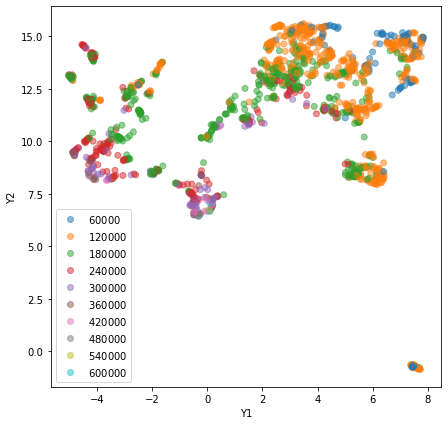

In [132]:
low_dim_scatter(X_umap)

In [133]:
umap_df = pd.DataFrame(X_umap, columns=["umap_dim1", "umap_dim2"])
umap_df

,umap_dim1,umap_dim2
0,-4.280313,11.939805
1,4.908229,13.295171
2,-3.537906,9.749142
3,2.949840,13.221790
4,-4.836404,9.514318
...,...,...
1404,-2.470601,11.459431
1405,2.301317,12.707479
1406,4.516701,11.435121
1407,6.194702,8.651078


### 5.3.1. K-means

In [134]:
inertias = []
silhouettes = []

possible_k = [i for i in range(2, 15)]
for k in possible_k:
    kmeans = KMeans(n_clusters=k, random_state=22)
    cluster_labels = kmeans.fit_predict(umap_df)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(umap_df, cluster_labels))

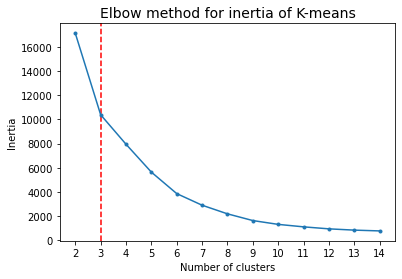

In [135]:
fig, ax = plt.subplots()
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Inertia')
ax.set_title('Elbow method for inertia of K-means', size=14)
ax.set_xticks(possible_k)
ax.axvline(x=3, color='red', linestyle='--')
plt.plot(possible_k, inertias, marker='.');

In [136]:
df_u = df.copy()
df_u['umap_dim1'] = umap_df['umap_dim1']
df_u['umap_dim2'] = umap_df['umap_dim2']

In [137]:
kmeans = KMeans(n_clusters=3, random_state=22)
y_kmeans = kmeans.fit_predict(umap_df)
df_u['kmeans_label'] = pd.Series(y_kmeans)
df_u.sort_values('kmeans_label', inplace=True)

In [161]:
#fig = px.scatter(
#    df_u,
#    x='umap_dim1', y='umap_dim2',
#    color='kmeans_label',
#    hover_data=df.columns)
#fig.update_layout(title='2D UMAP space (kmeans_label)', title_x=0.5)
#fig.show()

![jupyter](./КМИНС_ЮМАП.PNG)

In [139]:
df_u.groupby('kmeans_label').mean()

,SalePrice,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,TotalBsmtSF,GrLivArea,BedroomAbvGr,TotRmsAbvGrd,Fireplaces,GarageArea,umap_dim1,umap_dim2
kmeans_label,,,,,,,,,,,,,,
0,235193.990893,9853.380692,7.224044,5.069217,2001.373406,2002.018215,1236.923497,1705.442623,2.785064,6.896175,0.697632,591.859745,-2.327807,10.241920
1,137820.913333,9916.173333,5.193333,5.566667,1960.886667,1971.113333,828.126667,1278.666667,2.820000,5.986667,0.506667,415.733333,6.191442,6.357206
2,142099.887324,9478.211268,5.385915,5.980282,1951.642254,1974.547887,930.495775,1352.653521,2.880282,6.169014,0.530986,383.894366,4.466667,13.548460


Ситуация как и с t-SNE аналогичная. Интерпретация аналогичная.

In [140]:
df_u.groupby('kmeans_label').agg(agg_func_stats)

BsmtQual                                   ExterQual  \
              nunique           mode                set   nunique   
kmeans_label                                                        
0                   3  ([Gd], [431])       {TA, Ex, Gd}         3   
1                   3  ([TA], [100])  {nan, TA, Fa, Gd}         4   
2                   4  ([TA], [517])   {TA, Ex, Fa, Gd}         4   

                                              KitchenQual                 \
                       mode               set     nunique           mode   
kmeans_label                                                               
0             ([Gd], [408])      {TA, Ex, Gd}           3  ([Gd], [407])   
1             ([TA], [141])  {TA, Ex, Fa, Gd}           3  ([TA], [124])   
2             ([TA], [640])  {TA, Ex, Fa, Gd}           4  ([TA], [524])   

                               ExterCond                                       \
                           set   nunique           mode                   set   
kmeans_label                                                                    
0                 {TA, Ex, Gd}         2  ([TA], [535])              {TA, Gd}   
1                 {TA, Fa, Gd}         3  ([TA], [145])          {TA, Fa, Gd}   
2             {TA, Ex, Fa, Gd}         5  ([TA], [563])  {Po, Ex, Gd, TA, Fa}   

             HeatingQC                                      MSZoning  \
               nunique           mode                   set  nunique   
kmeans_label                                                           
0                    3  ([Ex], [487])          {TA, Ex, Gd}        4   
1                    4   ([TA], [75])      {Fa, Ex, Gd, TA}        3   
2                    5  ([TA], [326])  {Po, Ex, Gd, TA, Fa}        4   

                                                    
                       mode                    set  
kmeans_label                                        
0             ([RL], [453])       {RH, RM, RL, FV}  
1             ([RL], [143])           {RH, RM, RL}  
2             ([RL], [515])  {RH, RM, C (all), RL}

Исключительно интереса ради посмотрим, как будет выглядеть кластеризация при выделении большего числа кластеров.

In [162]:
#kmeans = KMeans(n_clusters=8, random_state=22)
#y_kmeans = kmeans.fit_predict(umap_df)
#df_u['kmeans_label1'] = pd.Series(y_kmeans)
#df_u.sort_values('kmeans_label1', inplace=True)

#fig = px.scatter(
#    df_u,
#    x='umap_dim1', y='umap_dim2',
#    color='kmeans_label1',
#    hover_data=df.columns)
#fig.update_layout(title='2D UMAP space (kmeans_label)', title_x=0.5)
#fig.show()

![jupyter](./КМИНС_ЮМАП1.PNG)

### 5.3.2. Иерархическая кластеризация

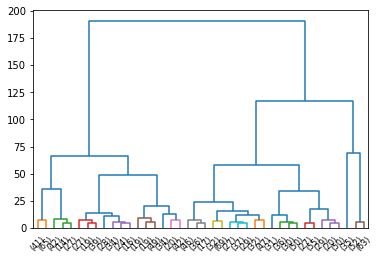

In [142]:
link = linkage(umap_df, method='ward', metric='euclidean')
dendrogram(link, truncate_mode='lastp', p=40, color_threshold=10)
plt.show()

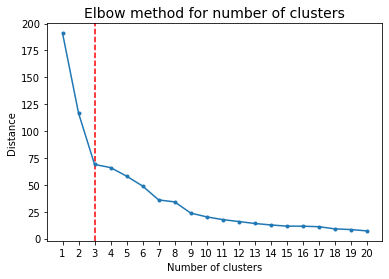

In [143]:
max_n = 20
xticks = 1 + np.arange(max_n)

fig = plt.figure()
plt.title('Elbow method for number of clusters', size=14)
plt.xlabel('Number of clusters')
plt.ylabel('Distance')
plt.xticks(xticks)
plt.axvline(x=3, color='red', linestyle='--')
plt.plot(xticks, link[-1:-max_n - 1:-1, 2], marker='.')
plt.show()

В этот раз иерархическая кластеризация дала 3 кластера, а не 4. Посмотрим поближе на это разделение:

In [144]:
hierarchical = AgglomerativeClustering(n_clusters=3,
                                       affinity='euclidean', linkage='ward')

y_hierarchical = hierarchical.fit_predict(umap_df)

df_u['hierarchical_label'] = pd.Series(y_hierarchical)

In [164]:
#fig = px.scatter(
#    df_u,
#    x='umap_dim1', y='umap_dim2',
#    color='hierarchical_label',
#    hover_data=df.columns)
#fig.update_layout(title='2D UMAP space (hierarchical label)', title_x=0.5)
#fig.show()

![jupyter](./Иерархическая_ЮМАП.PNG)

In [146]:
df_u.groupby('hierarchical_label').mean()

,SalePrice,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,TotalBsmtSF,GrLivArea,BedroomAbvGr,TotRmsAbvGrd,Fireplaces,GarageArea,umap_dim1,umap_dim2,kmeans_label,kmeans_label1
hierarchical_label,,,,,,,,,,,,,,,,
0,137820.913333,9916.173333,5.193333,5.566667,1960.886667,1971.113333,828.126667,1278.666667,2.820000,5.986667,0.506667,415.733333,6.191442,6.357206,1.000000,0.466667
1,235135.064401,9897.432916,7.220036,5.080501,2001.155635,2001.849732,1235.025045,1711.733453,2.801431,6.914132,0.692308,591.765653,-2.257302,10.258037,0.035778,4.193202
2,140817.028571,9437.672857,5.362857,5.984286,1951.105714,1974.290000,927.634286,1342.590000,2.868571,6.144286,0.532857,380.998571,4.507427,13.582826,2.000000,3.580000


В этот раз иерархическая кластеризация разделила данные на 3 кластера.

In [147]:
df_u.groupby('hierarchical_label').agg(agg_func_stats)

BsmtQual                                   ExterQual  \
                    nunique           mode                set   nunique   
hierarchical_label                                                        
0                         3  ([TA], [100])  {nan, TA, Fa, Gd}         4   
1                         3  ([Gd], [440])       {TA, Ex, Gd}         3   
2                         4  ([TA], [516])   {TA, Ex, Fa, Gd}         4   

                                                    KitchenQual  \
                             mode               set     nunique   
hierarchical_label                                                
0                   ([TA], [141])  {TA, Ex, Fa, Gd}           3   
1                   ([Gd], [415])      {TA, Ex, Gd}           3   
2                   ([TA], [637])  {TA, Ex, Fa, Gd}           4   

                                                    ExterCond                 \
                             mode               set   nunique           mode   
hierarchical_label                                                             
0                   ([TA], [124])      {TA, Fa, Gd}         3  ([TA], [145])   
1                   ([Gd], [413])      {TA, Ex, Gd}         2  ([TA], [542])   
2                   ([TA], [520])  {TA, Ex, Fa, Gd}         5  ([TA], [556])   

                                         HeatingQC                 \
                                     set   nunique           mode   
hierarchical_label                                                  
0                           {TA, Fa, Gd}         4   ([TA], [75])   
1                               {TA, Gd}         3  ([Ex], [493])   
2                   {Po, Ex, Gd, TA, Fa}         5  ([TA], [325])   

                                         MSZoning                 \
                                     set  nunique           mode   
hierarchical_label                                                 
0                       {TA, Ex, Fa, Gd}        3  ([RL], [143])   
1                           {TA, Ex, Gd}        4  ([RL], [463])   
2                   {Po, Ex, Gd, TA, Fa}        4  ([RL], [505])   

                                           
                                      set  
hierarchical_label                         
0                            {RH, RM, RL}  
1                        {RH, RM, RL, FV}  
2                   {RH, RM, C (all), RL}

Посмотрим на кластеризацию с выделением 6 кластеров.

In [148]:
hierarchical = AgglomerativeClustering(n_clusters=6,
                                       affinity='euclidean', linkage='ward')

y_hierarchical = hierarchical.fit_predict(umap_df)

df_u['hierarchical_label'] = pd.Series(y_hierarchical)

In [165]:
#fig = px.scatter(
#    df_u,
#    x='umap_dim1', y='umap_dim2',
#    color='hierarchical_label',
#    hover_data=df.columns)
#fig.update_layout(title='2D UMAP space (hierarchical label)', title_x=0.5)
#fig.show()

![jupyter](./Иерархическая_ЮМАП1.PNG)

In [150]:
df_u.groupby('hierarchical_label').mean()

,SalePrice,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,TotalBsmtSF,GrLivArea,BedroomAbvGr,TotRmsAbvGrd,Fireplaces,GarageArea,umap_dim1,umap_dim2,kmeans_label,kmeans_label1
hierarchical_label,,,,,,,,,,,,,,,,
0,219042.700000,9799.505405,7.010811,5.056757,2002.462162,2002.927027,1157.032432,1638.786486,2.816216,6.783784,0.602703,575.640541,-3.479808,10.964915,0.00000,3.432432
1,266638.634921,10089.142857,7.629630,5.126984,1998.597884,1999.740741,1387.708995,1854.539683,2.772487,7.169312,0.867725,623.333333,0.135964,8.874201,0.10582,5.682540
2,128968.551829,8088.033537,5.277439,6.201220,1942.573171,1974.018293,859.512195,1325.896341,2.783537,6.097561,0.435976,355.115854,6.117881,13.207872,2.00000,4.170732
3,106482.971429,9483.571429,4.371429,5.057143,1956.228571,1967.485714,0.000000,1289.457143,2.800000,6.342857,0.285714,366.057143,7.525762,-0.736340,1.00000,2.000000
4,147358.547826,10047.834783,5.443478,5.721739,1962.304348,1972.217391,1080.165217,1275.382609,2.826087,5.878261,0.573913,430.852174,5.785344,8.516112,1.00000,0.000000
5,151264.072581,10627.677419,5.438172,5.793011,1958.629032,1974.529570,987.698925,1357.309140,2.943548,6.185484,0.618280,403.819892,3.087456,13.913429,2.00000,3.059140


### 5.3.3. DBSCAN

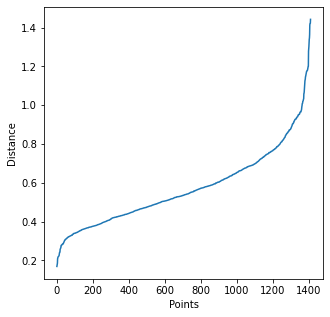

In [151]:
nearest_neighbors1 = NearestNeighbors(n_neighbors=31)
neighbors1 = nearest_neighbors1.fit(umap_df)
distances, indices = neighbors1.kneighbors(umap_df)

distances = np.sort(distances[:, 30], axis=0)
i = np.arange(len(distances))
knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')

fig = plt.figure(figsize=(5, 5))
plt.plot(distances)
plt.xlabel("Points")
plt.ylabel("Distance");

plt.savefig("Distance_curve.png", dpi=300)

0.7885555046916146


<Figure size 360x360 with 0 Axes>

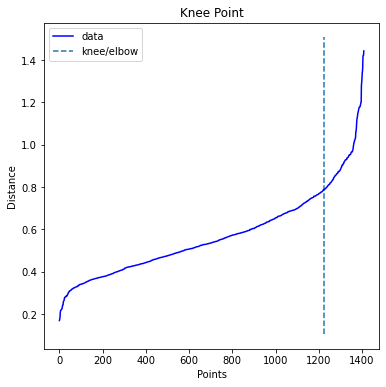

In [152]:
fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")
plt.savefig("knee.png", dpi=300)
print(distances[knee.knee])

In [153]:
dbscan = DBSCAN(eps=distances[knee.knee], min_samples=30)
y_dbscan = dbscan.fit_predict(umap_df)

df_u['dbscan_label'] = pd.Series(y_dbscan).apply(lambda x: '0' + str(x) if 0 <= x < 10 else str(x))

In [166]:
#fig = px.scatter(
#    df_u,
#    x='umap_dim1', y='umap_dim2',
#    color='dbscan_label',
#    hover_data=df.columns)
#fig.update_layout(title='2D UMAP space (dbscan_label)', title_x=0.5)
#fig.show()

![jupyter](./ДБСКАН_ЮМАП.PNG)

## Сравнительный анализ результатов кластеризации данных без уменьшения размерности и с использованием разных способов уменьшения размерности.

### 1. Без уменьшения размерности VS МГК

Можно отметить низкое качество  (на фоне других способов кластеризации) работы метода DBSCAN в обоих случаях.

K-means и иерархическая кластеризация показали схожие результаты: средние значения признаков отличались незначительно.

### 2. Без уменьшения размерности VS t-SNE

K-means после уменьшения размерности выделил то же число кластеров (3), для некоторых признаков разделение на кластеры стало видно четче.

Иерархическая кластеризация после уменьшения размерности выделила на 1 кластер больше (5). В целом разделение стало лучше, но для двух кластеров некоторые признаки.

DBSCAN сработал плохо.

### 3. Без уменьшения размерности VS UMAP

K-means сохранил первоначальное число кластеров, но качество разделения на кластеры снизилось. 

Иерархическая кластеризация выделила на 1 кластер меньше (3), качество разделения на кластеры также снизилось. 

DBSCAN сработал лучше, выделил 9 кластера + выбросы, исходя из визуализации разделение четкое.

## P.S. 

К сожалению,я была вынуждена заслэшить код и заменить все графики визуализации кластеризации на скрины реализации, пока она еще не умерла, поскольку px.scatter умирал по мере добавления новых графиков/по истечению какого-то времени.

![jupyter](./СМЕРТЬ.PNG)